# Pneumonia Detection Using Classification Algorithims and Convolutional Neural Networks
Owen Ostermann

DATA 3010

December 11, 2023

#Introduction

The data used in this project was taken from the page https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia, which is publicly available to use. The data contains 5,863 X-ray images and two categories (Pneumonia or Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. All chest radiographs were screened for quality control by removing low-quality or unreadable scans. The images’ labels were done by two physicians at the hospital before being cleared for release, ensuring that the proper labels were assigned to the right images.


In this project, I attempt to explore multiple different classification algorithms, dimensionality reduction, and neural networks to create a solution to use on the dataset. I want to be able to find a combination of methods that most accurately predicts based on the X-ray scan if a patient has pneumonia or not. I will explore various dimensionality reduction techniques such as principal component analysis (PCA) and t-distributed stochastic neighbor embedding (t-SNE). Once explored, I will try to do some clustering in an unsupervised fashion to explore some of the dynamics of the data through k-means++. Finally, I will attempt to use various supervised classification algorithms such as stochastic gradient descent classifiers, support vector machines, random forests, logistic regression, k-nearest neighbors, Gaussian naive Bayes classifiers, basic sequential neural networks, and some convolutional neural networks. I will evaluate each of the algorithms' output by assessing things like accuracy, precision, recall, F1, precision recall curves, and receiver operating characteristic curves to assess the area under the curve of the true positive versus false positive rates.

The first step of the project is to import the required packages, mount to google drive so that the collab notebook can access the X-ray scan images, read in the data and clean it up to it can be used for classification (flatten the pixels into 1D arrays).

#Imports

This is a place to import everything that I need for this project, we run it once at the beginning so that all the required functions are already imported for the entire project. We also set soem seeds for reproducibility purposes.

In [ ]:

import os
import pathlib
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from PIL import Image
from numpy import asarray
from google.colab import drive

import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding, TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import learning_curve, train_test_split, cross_val_score,
StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import entropy
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding

#set random seeds
np.random.seed(3010)
random.seed(3010)
tf.random.set_seed(3010)

#Mount to Google Chrome

Here I mount to my google drive, in order to access the data that is stored in my drive, I have to connect the colab notebook to be able to pull the images for my project.

In [ ]:
#connect to google drive account to access the data
drive.mount('/content/drive')

#path to image folder in google drive
image_folder_path = '/content/drive/My Drive/chest_xray'

Mounted at /content/drive


#Preliminary Functions

A bunch of prelimnary functions for loading the data, plotting some of the scans, counting the classes, and removing a couple images that are not in a usable format in the data.

In [ ]:
#function to read in the images
def load_data(path):
    """
    This is a function that reads in the images and stores the grayscale pixels (0-255,
    0 is black and 255 is white) into the variable X. Since all of the images are of
    different pixel dimensions, we resize them to 256 by 256 pixels
    for consistency. We then flatten each image into a 1D array of these
    pixel values so it is easier to pass into the models that we will be using.
    Further we also store the labels (pneumonia = 1 and normal = 0) into a y variable
    that is of identical size.

    Parameters:
    - path (str): The path name of my google drive that stores the images.

    Returns:
    - X (2d array): An array of length 5857 (how many images), each of the 5857 images
      are represented by an array of length 256x256 = 65536 pixel values in the 0-255 grayscale
    - y (1d array): An array of length 5857 that stores 1's and 0's as the binary class label.
    """
    image_paths = [os.path.join(path, filename) for filename in os.listdir(path) if
                   filename.endswith(('.jpeg'))]
    image_count = len(image_paths)

    X = []
    y = np.empty(image_count, dtype=int)

    for i, img_path in enumerate(image_paths):
        if "pneumonia" in img_path.lower():
            y[i] = 1  # Label for pneumonia
        else:
            y[i] = 0  # Label for not pneumonia

        # Load the image using PIL and resize it
        image = Image.open(img_path).resize((256, 256))
        image = np.array(image).flatten() # flatten it so we have a 1D array of pixels
        X.append(image)

    X = np.array(X)

    return X, y


# for labelling images
def label_for_scan(number):
    """
    This is a function that is used in the function below "plot_scan". It's only purpsoe is to
    add the class label at the top of the image when we plot them.

    Parameters:
    - number (int): passed either a 1 or 0 depenidng on what is stored in the y label array
      for that specific image.

    Returns:
    - strings: either returns normal if the label is 0 and pneumonia if the label is 1.
    """
    if number == 0:
      return "normal x-ray scan"
    elif number == 1:
      return "pneumonia x-ray scan"
    else:
      return number


#for plotting the images
def plot_scan(image, label):
    """
    This is a function that plots the 1D array of pixels back into an image so we
    can see what we are working with.
    It first takes the 1d array and converts it back to its original 256x256 matrix.
    We show the image then in grayscale.
    Then use the "label_for_scan" function to plot the title of the image.

    Parameters:
    - image (1d array): the array of pixels in a 1D form
    - label (int): the binary label of either 1 or 0 (pneumonia or normal)

    Returns:
    - plots the image of the chest x-ray scan
    """
    image_2d = image.reshape((256,256))
    plt.imshow(image_2d, cmap='gray')
    plt.title(label_for_scan(label))
    plt.axis('off')
    plt.show()


#function for checking how many normal images and pneumonia images we have
def classes_counts(labels):
    """
    This is a function that counts how many of each class in the data. It loops
    through the labels array and updates the pneumonia counter if it is a 1 and
    the normal tracker if it is 0. It then prints in
    a nice format.

    Parameters:
    - labels (1d array): the array of labels represneted by 1's and 0's

    Returns:
    - prints out the count of labels of each binary class
    """
    pneumonia_count = 0
    normal_count = 0
    for i in range(len(labels)):
      if labels[i] == 0:
        normal_count += 1
      else:
        pneumonia_count += 1
    return (f'Pneumonia Count: {pneumonia_count}, Normal Count: {normal_count}')



#function to remove the 200 data points that are weird sizes and not consistent
def removeBadDimesnions(images, labels):
    """
    This is a function that removes some of the images that are nto consistent sizes.
    There is not many to remove, about 200 total, so we just remove them

    Parameters:
    - images (1d array): the array of pixels in a 1D form
    - labels (1d array): the array of labels represneted by 1's and 0's

    Returns:
    - prints out the count of labels of each binary class
    """
    good_images = []
    good_labels = []

    for i in range(len(images)):
      if len(images[i]) == 65536:
        good_images.append(images[i])
        good_labels.append(labels[i])
    return good_images,good_labels

# Load Data
We load in the data and scale each image to a matrix of 256x256 pixels, which are all grayscale. The grayscale range goes from 0 to 255, where 0 is completely black and 255 is completely white. We flatten each of the matrices that is an X-ray image into a 1D array of length 65,536 pixels. This makes it much easier for our classification algorithms. We will resize the images back to 256x256 matrices when we do CNNs.

In [ ]:
X_all, y_all = load_data(image_folder_path)
X, y = removeBadDimesnions(X_all, y_all)

<ipython-input-3-a407d8ce5957>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


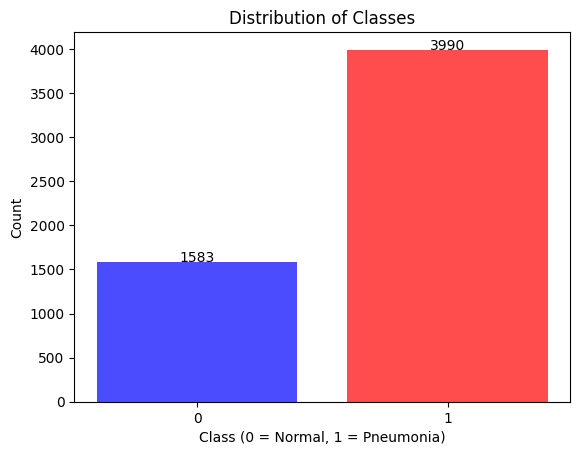

Proportion of Normal Scans: 28.405 %
Proportion of Pneumonia Scans: 71.595 %


In [ ]:
# Count the occurrences of each unique value in y
unique, counts = np.unique(y, return_counts=True)

# Bar chart
plt.bar(unique, counts, color=['blue', 'red'], alpha = 0.7)
plt.xlabel('Class (0 = Normal, 1 = Pneumonia)')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.xticks(unique)

# Display counts on top of each bar
for i, count in enumerate(counts):
    plt.text(unique[i], count + 0.1, str(count), ha='center')

plt.show()

print("Proportion of Normal Scans:", round((counts[0]/(counts[0]+counts[1]))*100, 3), '%')
print("Proportion of Pneumonia Scans:", round((counts[1]/(counts[0]+counts[1]))*100, 3), '%')

Here we can see the slight class imbalance in our data. We have 3,990 pneumonia X-ray scans and 1,583 normal X-ray scans. We have approximately a 70:30 ratio of pneumonia to normal scans. There are a number of ways that class imbalance can affect classification algorithms. First, it can lead to overfitting. This is because the algorithm will tend to focus on the majority class, and may not learn to generalize well to the minority class. In our case, we could overfit the pneumonia class. Second, it can lead to underfitting. This is because the algorithm may not have enough data from the minority class to learn a good decision boundary. For example, the algorithm may not see enough normal scans to be able to distinguish what a normal scan actually is. Third, it can lead to bias. This is because the algorithm may be more likely to predict the majority class, even when it is not the correct prediction. We may predict pneumonia when it is actually normal.

In order to combat this issue, what I have chosen to use is stratified sampling. This is a sampling technique that is used to ensure that each class is represented in the sample in proportion to its size in the population. This is done by dividing the population into strata, which are groups of data points that share similar characteristics. Then, a random sample is taken from each stratum, ensuring that each class is represented in the sample.

#Data Visualization

In order to get a sense of the data dynamics, we are going to use some of the dimensionality reduction techniques mentioned in the introduction and scale them down to the second dimesnion. We do this to visually see how the data is split using the different forms of dimensionality reduction techniques. Since our data is extremly complex and high level (it is composed of 65536 data points of pixels for each of the 5573 images) it would make sense to find a way that we could reduce the data while retianing as much information as possible to speed up the computation time of our classifcation algorihtims while not losing information.  

**1. Principle Component Analysis**

Principal component analysis (PCA) is a statistical procedure that uses orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables. PCA works by finding the directions in which the data has the most variance. The first principal component is the direction in which the data has the most variance, the second principal component is the direction in which the data has the second most variance, and so on. Once the principal components have been found, the data can be projected onto them. This means that each data point can be represented as a point in a new coordinate system, where the axes are the principal components.

When we reduce the number of principal components to two, we can visualize the data in a two-dimensional space. This can be helpful for understanding the relationships between the different variables in the data, specifically to see the differences in pneumonia scans versus normal scans.

Explained Variance for PC1: 24.8522
Explained Variance for PC2: 10.3486


<ipython-input-5-4254ca63c4d9>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_normalized_PCA[:, 0], X_normalized_PCA[:, 1], s=10, cmap=plt.cm.get_cmap('coolwarm', 2), c=y, alpha = 0.5)


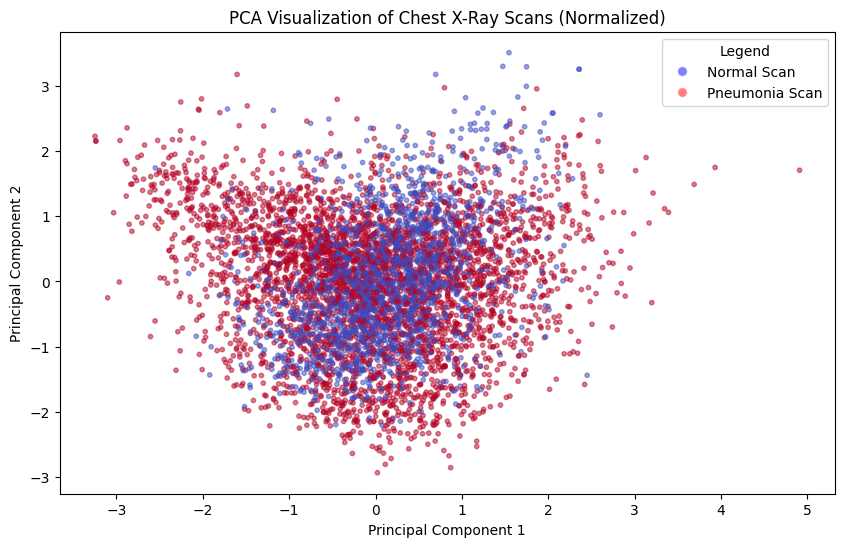

In [ ]:
# Apply PCA to data
pca = PCA(n_components=2, random_state= 3010)
reduced_data_PCA = pca.fit_transform(X) # we use the whole dataset for unsupervized learning

# Standard Scaler, this is just for better intution in the plot
# The data has a mean of 0 and a standard deviation of 1
scaler_PCA = StandardScaler()
X_normalized_PCA = scaler_PCA.fit_transform(reduced_data_PCA)

# Calculate the explained variance for each principal component
explained_variance = pca.explained_variance_ratio_ * 100

# Display the explained variance for each component
for i, ev in enumerate(explained_variance):
    print(f"Explained Variance for PC{i + 1}: {ev:.4f}")

# Create a scatter plot of the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(X_normalized_PCA[:, 0], X_normalized_PCA[:, 1], s=10,
            cmap=plt.cm.get_cmap('coolwarm', 2), c=y, alpha = 0.5)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Normal Scan',
                      markersize=7, markerfacecolor='blue', alpha=0.5),
           plt.Line2D([0], [0], marker='o', color='w', label='Pneumonia Scan',
                      markersize=7, markerfacecolor='red', alpha=0.5)]

plt.legend(handles=handles, title='Legend')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Chest X-Ray Scans (Normalized)')
plt.show()

PCA does not take a lot of computational time to run, which is a desirable part about it. This is due to it being one of the simplest and straightforward dimensionality reduction techniques. The simple nature, however, does not seem to work out for us here. We can see that in the image that there is no real definitive separation between the normal scans in blue and the pneumonia scans in red. Another thing to note is that the components have been passed through a standard scaler and normalized to have a mean of zero and standard deviation of 1. We also computed the variance explained by each principal component. Component one explains about 24.852%, and component two explains 10.349%. So scaling down from 65,536 dimensions to two is still able to retain about 35% of the variance from the original data. We want to try some other techniques to see if we can find a two-dimensional representation that is able to split the two classes better than PCA does here.

**2. Locally Linear Embedding**

When we run locally linear embedding, there are a couple extreme outliers which made it hard to visually see what was going on due to the scales. My intution on why this is happening is due to the data being extremly high-dimensional. LLE is a dimensionality reduction technique, so it is designed to work with high-dimensional data. However, if the data is too high-dimensional, then LLE may not be able to find a good embedding. This can lead to extreme outliers. So we dont consider LLE

<ipython-input-25-d110582356ef>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_normalized_lle[:, 0], X_normalized_lle[:, 1], s=10, cmap=plt.cm.get_cmap('coolwarm', 2), c=y, alpha=0.5)


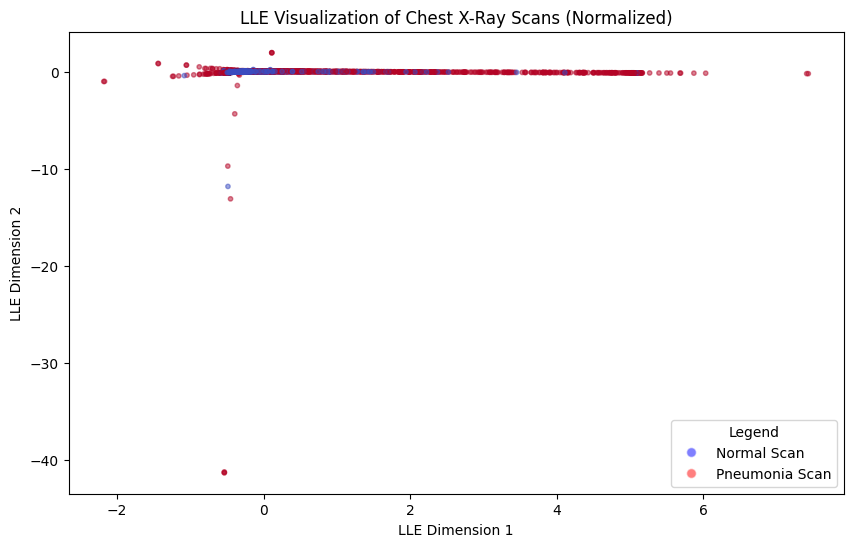

In [ ]:
# Create our LLE reduced data
lle = LocallyLinearEmbedding(n_components=2, random_state=3010)

# Convert our input into a numpy array from a list for the LLE function
X_nump = np.array(X)

reduced_data_lle = lle.fit_transform(X_nump)  # we use the whole dataset for unsupervised learning

# Standard Scaler, this is just for better intuition in the plot
# The data has a mean of 0 and a standard deviation of 1
scaler_lle = StandardScaler()
X_normalized_lle = scaler_lle.fit_transform(reduced_data_lle)

# Create a scatter plot of the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(X_normalized_lle[:, 0], X_normalized_lle[:, 1], s=10,
            cmap=plt.cm.get_cmap('coolwarm', 2), c=y, alpha=0.5)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Normal Scan',
                      markersize=7, markerfacecolor='blue', alpha=0.5),
           plt.Line2D([0], [0], marker='o', color='w', label='Pneumonia Scan',
                      markersize=7, markerfacecolor='red', alpha=0.5)]

plt.legend(handles=handles, title='Legend')
plt.xlabel('LLE Dimension 1')
plt.ylabel('LLE Dimension 2')
plt.title('LLE Visualization of Chest X-Ray Scans (Normalized)')
plt.show()

**3. t-SNE**

T-SNE, or t-distributed stochastic neighbor embedding, is a dimensionality reduction technique that is used to visualize high-dimensional data. It works by first constructing a graph over the data points, where each data point is connected to its nearest neighbors. The weights of the edges in the graph are then calculated based on the probability that two data points are neighbors based on the t-distribution. Once the graph is constructed, T-SNE proceeds to embed the data points in a lower-dimensional space. This is done by minimizing a cost function that measures the difference between the pairwise distances between the data points in the original space and the pairwise distances between the data points in the lower-dimensional space.

T-SNE is a powerful technique for visualizing high-dimensional data. It is able to preserve the local structure of the data, which makes it easy to see how the data points are clustered together. T-SNE is also relatively fast, making it suitable for use with large datasets like our chest X-ray dataset.

<ipython-input-6-e4793bb0bc83>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_normalized_tsne[:, 0], X_normalized_tsne[:, 1], s=10, cmap=plt.cm.get_cmap('coolwarm', 2), c=y, alpha = 0.5)


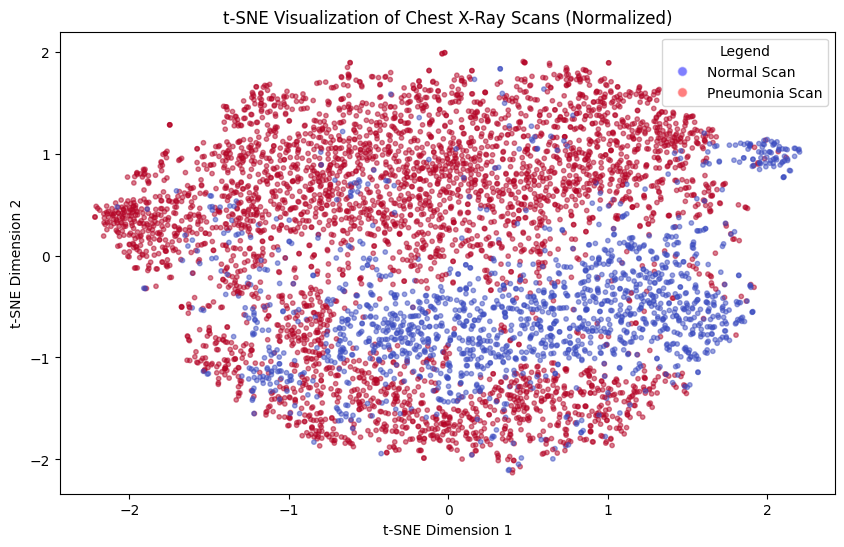

In [ ]:
# Create our t-SNE reduced data
tsne = TSNE(n_components=2, random_state= 3010)

# convert our input into a numpy array from a list for the TSNE function
X_nump = np.array(X)

reduced_data_tsne = tsne.fit_transform(X_nump) # we use the whole dataset for unsupervized learning

# Standard Scaler, this is just for better intution in the plot
# The data has a mean of 0 and a standard deviation of 1
scaler_tsne = StandardScaler()
X_normalized_tsne = scaler_tsne.fit_transform(reduced_data_tsne)

# Create a scatter plot of the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(X_normalized_tsne[:, 0], X_normalized_tsne[:, 1], s=10,
            cmap=plt.cm.get_cmap('coolwarm', 2), c=y, alpha = 0.5)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Normal Scan',
                      markersize=7, markerfacecolor='blue', alpha=0.5),
           plt.Line2D([0], [0], marker='o', color='w', label='Pneumonia Scan',
                      markersize=7, markerfacecolor='red', alpha=0.5)]

plt.legend(handles=handles, title='Legend')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Chest X-Ray Scans (Normalized)')
plt.show()

Again, the dimensions have been taken from 65,536 to two and they have both been normalized for visualization and consistency purposes. We can see that this is significantly better than PCA and LLE for separation purposes. Most of the top part of the cluster of data points is pneumonia scans, and the middle is composed of normal scans. The bottom is a mix of blue and red scans. This bottom portion could be ones that are very similar images that may have very mild pneumonia infection so it looks close to a normal image. But overall, we see a good separation between the two. This is the best we have gotten so far.

**4. Multidimensional Scaling**

Multidimensional scaling (MDS) is a dimensionality reduction technique that is used to visualize high-dimensional data. It works by first constructing a graph over the data points, where each data point is connected to its nearest neighbors. The weights of the edges in the graph are then calculated based on the pairwise distances between the data points. Once the graph is constructed, MDS proceeds to embed the data points in a lower-dimensional space. This is done by minimizing a cost function that measures the difference between the pairwise distances between the data points in the original space and the pairwise distances between the data points in the lower-dimensional space.

MDS is different from t-SNE in that it does not use a probability distribution to calculate the weights of the edges in the graph. Instead, it uses the pairwise distances between the data points. This makes MDS more robust to outliers and noise in the data.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
<ipython-input-24-bb9b97dbe9fe>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_normalized_mds[:, 0], X_normalized_mds[:, 1], s=10, cmap=plt.cm.get_cmap('coolwarm', 2), c=y, alpha=0.5)


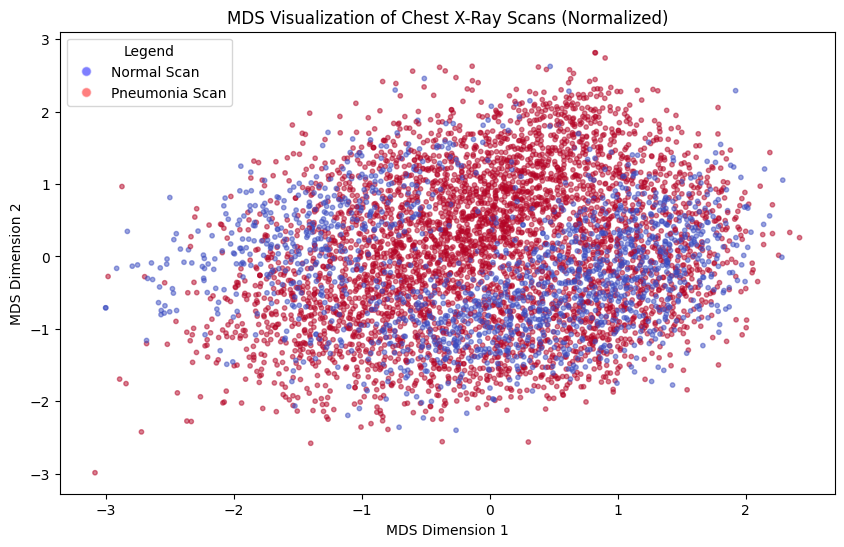

In [ ]:
# Create our MDS reduced data
mds = MDS(n_components=2, random_state=3010)

# Convert our input into a numpy array from a list for the MDS function
X_nump = np.array(X)

reduced_data_mds = mds.fit_transform(X_nump)  # we use the whole dataset for unsupervised learning

# Standard Scaler, this is just for better intuition in the plot
# The data has a mean of 0 and a standard deviation of 1
scaler_mds = StandardScaler()
X_normalized_mds = scaler_mds.fit_transform(reduced_data_mds)

# Create a scatter plot of the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(X_normalized_mds[:, 0], X_normalized_mds[:, 1], s=10,
            cmap=plt.cm.get_cmap('coolwarm', 2), c=y, alpha=0.5)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Normal Scan',
                      markersize=7, markerfacecolor='blue', alpha=0.5),
           plt.Line2D([0], [0], marker='o', color='w', label='Pneumonia Scan',
                      markersize=7, markerfacecolor='red', alpha=0.5)]

plt.legend(handles=handles, title='Legend')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Visualization of Chest X-Ray Scans (Normalized)')
plt.show()

We can see that it has a simialir shape to the T-SNE visual, but there is less seperation between the red and the blue dots. It also takes much longer to compute than T-SNE and PCA. MDS is a more complex algorithm than t-SNE and PCA, and it requires more computation to find the optimal embedding. This is because MDS takes into account the pairwise distances between all of the data points, while t-SNE and PCA only consider the distances between a subset of the data points. As a result, MDS is more sensitive to the number of data points and the dimensionality of the embedding space.

##K-means++ Clustering

K-means++ clustering can be used on our binary classification problem to identify clusters of data points that are similar to each other. This information can be used to understand the structure of the data. There are some interesting results that occur within the data that K-means++ picks up on.

But why K-means++ and not just the classical approch of using k-means? K-means++ is a variant of the k-means clustering algorithm that is designed to improve the quality of the clustering. K-means++ works by randomly selecting one data point as the first cluster center. It then iteratively selects the next cluster center as the data point that is farthest from the existing cluster centers. This process is repeated until the desired number of clusters has been created. K-means++ is typically faster than k-means, and it often produces better quality clusters. This is because k-means++ is less likely to produce clusters that are too large or too small. K-means++ is also less likely to produce clusters that are not well-separated.

We are going to find what K-means++ deems as the "optimal" number of clusters through the silhouette score and inertia (elbow method), then we are going to see some sample images from each of the clusters with thier label (pneumonia or normal) to see if the clusters contain one or the other, or both. We will do this with the two dimensional PCA data and with the two dimesional T-SNE data as this was our best visual above, and I do not want to count out PCA just yet.

1. With PCA Data First

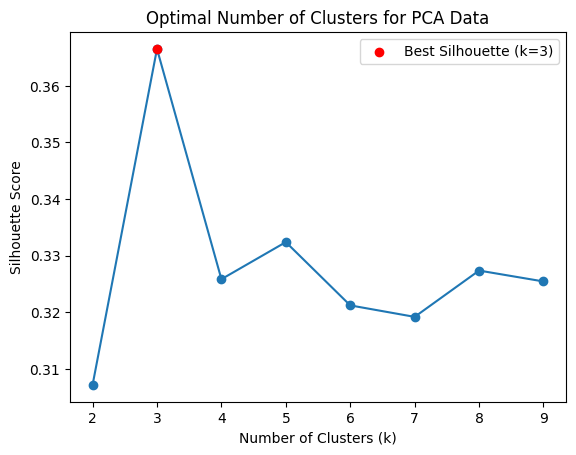

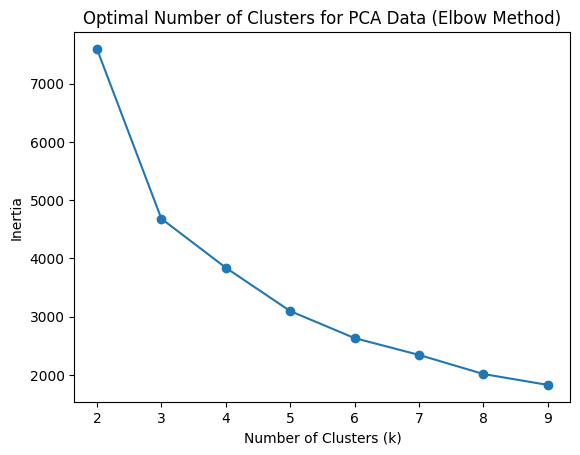

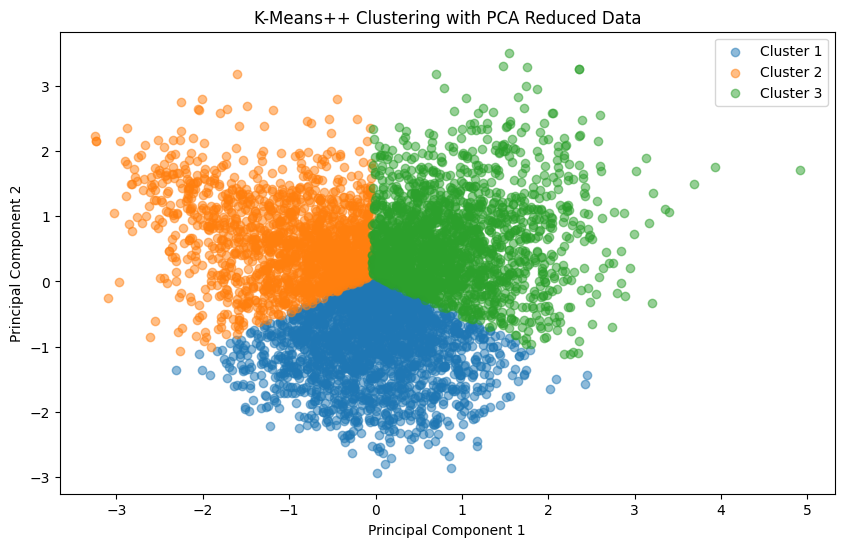

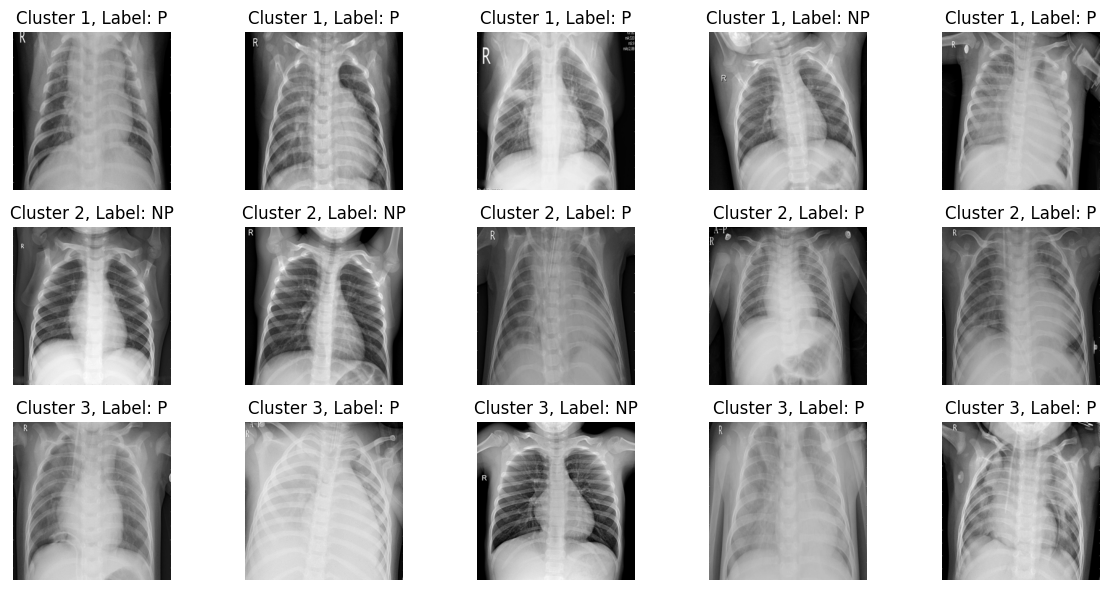

In [ ]:
#shuffle the data first
y = np.array(y)
X = np.array(X)
y_shuffled = y.copy()  # Create a copy to avoid modifying the original array
X_normalized_PCA_shuffled = X_normalized_PCA.copy()
X_shuffled = X.copy()

# Shuffle the arrays
shuffled_indices = np.arange(len(y_shuffled))
np.random.shuffle(shuffled_indices)

y_shuffled = y_shuffled[shuffled_indices]
X_normalized_PCA_shuffled = X_normalized_PCA_shuffled[shuffled_indices]
X_shuffled = X_shuffled[shuffled_indices]

# Now compare this by using the PCA reduced data
# Determine the optimal number of clusters using the Elbow method and Silhouette score for PCA data
k_values_pca = range(2, 10)
silhouette_scores_pca = []
inertia_scores_pca = []

# Use normalized PCA data to speed up training time
for k in k_values_pca:
    kmeans_pca = KMeans(n_clusters=k, random_state=3010, n_init = "auto", init = "k-means++")
    cluster_labels_pca = kmeans_pca.fit_predict(X_normalized_PCA_shuffled)
    silhouette_avg_pca = silhouette_score(X_normalized_PCA_shuffled, cluster_labels_pca)
    silhouette_scores_pca.append(silhouette_avg_pca)
    inertia_pca = kmeans_pca.inertia_
    inertia_scores_pca.append(inertia_pca)

# Find the index of the best silhouette score
best_k_pca = k_values_pca[silhouette_scores_pca.index(max(silhouette_scores_pca))]

# Visualize the Silhouette score plot for PCA data to determine the optimal k
plt.plot(k_values_pca, silhouette_scores_pca, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters for PCA Data')

# Plot the red point with the best silhouette score
plt.scatter(best_k_pca, max(silhouette_scores_pca), color='red',
            label=f'Best Silhouette (k={best_k_pca})', zorder=10)
plt.legend()
plt.show()

# Visualize the inertia score for PCA data
plt.plot(k_values_pca, inertia_scores_pca, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Optimal Number of Clusters for PCA Data (Elbow Method)')
plt.show()

# We have determined the optimal k, fit K-Means with that value using PCA data
optimal_k_pca = best_k_pca
kmeans_pca = KMeans(n_clusters=optimal_k_pca, random_state=3010,
                    n_init = "auto", init = "k-means++")
cluster_labels_pca = kmeans_pca.fit_predict(X_normalized_PCA_shuffled)

# Plot the clusters for pca data with legend
plt.figure(figsize=(10, 6))
for cluster_num in range(optimal_k_pca):
    cluster_points = X_normalized_PCA_shuffled[cluster_labels_pca == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                label=f'Cluster {cluster_num + 1}', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means++ Clustering with PCA Reduced Data')
plt.legend()
plt.show()


# Visualize sample images from each of the clusters for t-SNE data
cluster_images_pca = {i: {'images': [], 'labels': []} for i in range(best_k_pca)}

# Organize images into their respective clusters
for i, (label, image) in enumerate(zip(cluster_labels_pca, X_shuffled)):
    cluster_images_pca[label]['images'].append(image)
    cluster_images_pca[label]['labels'].append(y_shuffled[i])
     # X contains image data, y contains labels

fig, axes = plt.subplots(nrows=best_k_pca, ncols=5, figsize=(12, 2 * best_k_pca))
for i in range(best_k_pca):
    for j in range(5):  # Display up to 5 images from each cluster
        ax = axes[i, j]
        image = cluster_images_pca[i]['images'][j]
        label = cluster_images_pca[i]['labels'][j]
        label_name = 'P' if label == 1 else 'NP'
        ax.imshow(image.reshape(256, 256), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Cluster {i+1}, Label: {label_name}')
plt.tight_layout()
plt.show()

We can see that the "optimal" number of clusters selected is 3. This is interesting as we have a binary situtation, we can have pneumonia or no pneumonia. In the kaggle dataset description, it is mentioned that there is actually 3 different situations we could see in the X-ray scans; normal, bacterial pneumonia, and viral pneumonia. K-means is picking up on this idea of three different situtations. The last image, showing the actual X-rays does not tell us much as the blue and the red in the PCA image were clustered all over the place, so we dont get any super interesting results.

2. With t-SNE Data

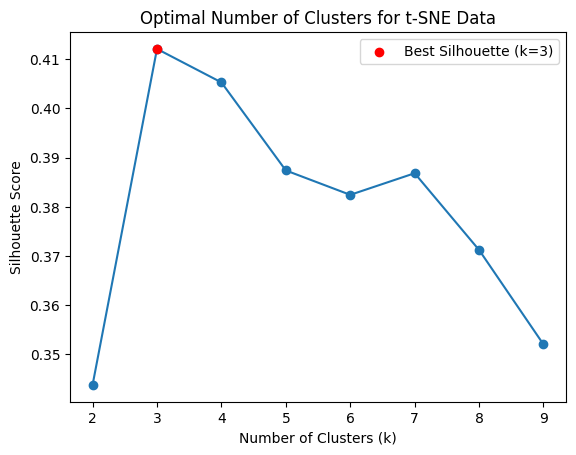

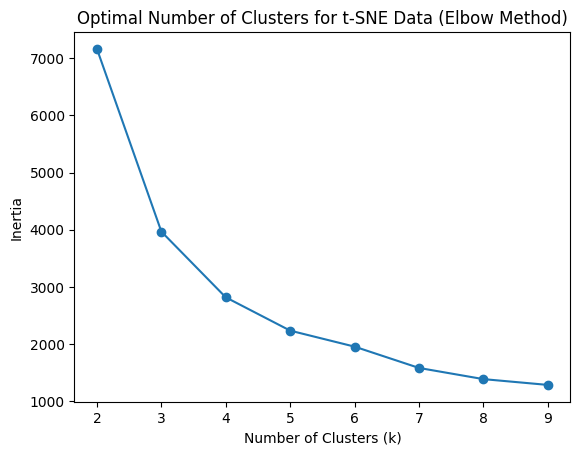

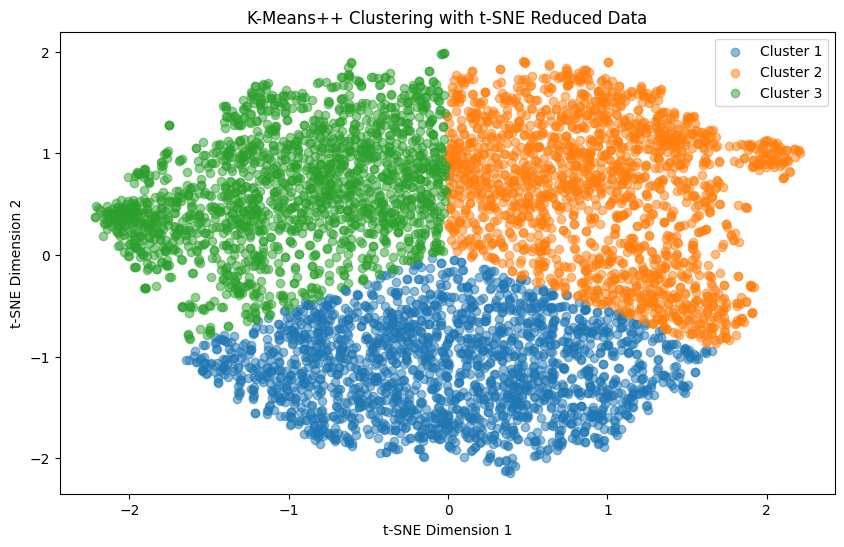

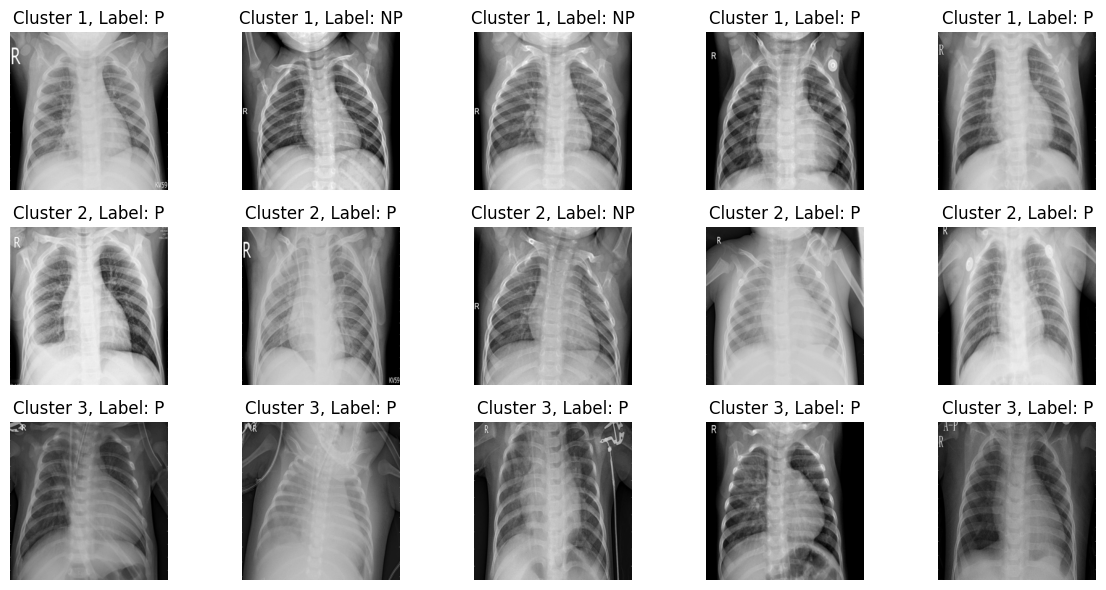

In [ ]:
#shuffle the data first
y = np.array(y)
X = np.array(X)
y_shuffled = y.copy()  # Create a copy to avoid modifying the original array
X_normalized_tsne_shuffled = X_normalized_tsne.copy()
X_shuffled = X.copy()

# Shuffle the arrays
shuffled_indices = np.arange(len(y_shuffled))
np.random.shuffle(shuffled_indices)

y_shuffled = y_shuffled[shuffled_indices]
X_normalized_tsne_shuffled = X_normalized_tsne_shuffled[shuffled_indices]
X_shuffled = X_shuffled[shuffled_indices]

# Determine the optimal number of clusters using the Elbow method or
# Silhouette score for t-SNE data
k_values_tsne = range(2, 10)
silhouette_scores_tsne = []
inertia_scores_tsne = []

# Use normalized t-SNE data to speed up training time
for k in k_values_tsne:
    kmeans_tsne = KMeans(n_clusters=k, random_state=3010, n_init = "auto", init = "k-means++")
    cluster_labels_tsne = kmeans_tsne.fit_predict(X_normalized_tsne_shuffled)
    silhouette_avg_tsne = silhouette_score(X_normalized_tsne_shuffled, cluster_labels_tsne)
    silhouette_scores_tsne.append(silhouette_avg_tsne)
    inertia_tsne = kmeans_tsne.inertia_
    inertia_scores_tsne.append(inertia_tsne)

# Find the index of the best silhouette score
best_k_tsne = k_values_tsne[silhouette_scores_tsne.index(max(silhouette_scores_tsne))]

# Visualize the Silhouette score plot for t-SNE data to determine the optimal k
plt.plot(k_values_tsne, silhouette_scores_tsne, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters for t-SNE Data')

# Plot the red point with the best silhouette score
plt.scatter(best_k_tsne, max(silhouette_scores_tsne), color='red',
            label=f'Best Silhouette (k={best_k_tsne})', zorder=10)
plt.legend()
plt.show()

# Visualize the inertia score for t-SNE data
plt.plot(k_values_tsne, inertia_scores_tsne, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Optimal Number of Clusters for t-SNE Data (Elbow Method)')
plt.show()

# We have determined the optimal k, fit K-Means with that value using t-SNE data
optimal_k_tsne = best_k_tsne
kmeans_tsne = KMeans(n_clusters=optimal_k_tsne, random_state=3010,
                     n_init = "auto", init = "k-means++")
cluster_labels_tsne = kmeans_tsne.fit_predict(X_normalized_tsne_shuffled)

# Plot the clusters for t-SNE data with legend
plt.figure(figsize=(10, 6))
for cluster_num in range(optimal_k_tsne):
    cluster_points = X_normalized_tsne_shuffled[cluster_labels_tsne == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                label=f'Cluster {cluster_num + 1}', alpha=0.5)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('K-Means++ Clustering with t-SNE Reduced Data')
plt.legend()
plt.show()


# Visualize sample images from each of the clusters for t-SNE data
cluster_images_tsne = {i: {'images': [], 'labels': []} for i in range(best_k_tsne)}

# Organize images into their respective clusters
for i, (label, image) in enumerate(zip(cluster_labels_tsne, X_shuffled)):
    cluster_images_tsne[label]['images'].append(image)
    cluster_images_tsne[label]['labels'].append(y_shuffled[i])
    # X contains image data, y contains labels

fig, axes = plt.subplots(nrows=best_k_tsne, ncols=5, figsize=(12, 2 * best_k_tsne))
for i in range(best_k_tsne):
    for j in range(5):  # Display up to 5 images from each cluster
        ax = axes[i, j]
        image = cluster_images_tsne[i]['images'][j]
        label = cluster_images_tsne[i]['labels'][j]
        label_name = 'P' if label == 1 else 'NP'
        ax.imshow(image.reshape(256, 256), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Cluster {i+1}, Label: {label_name}')
plt.tight_layout()
plt.show()

We can see an extremly interesting result here. Cluster 1, which is the bottom in blue, if you remember the T-SNE visual, the bottom was mainly normal scans with the exception of some pneumonia scans mixed in here and there. We can see that taking the sample clusters that cluster 1 contains 2 non pnemonias and 3 pneumonia scans. Clusters 2 and 3 consist of mainly pneumonia scans as this part of the T-SNE graph was mainly all red dots, or pneumonia dots.

The underlying data is very complex, our images are 256 x 256, so we were not expecting much from the unsupervised learning portion of the project, but it was interesting to explore which dimensionality reduction techniques worked and did not work, now we have an idea of which would be the best if we need to do reduction of dimensions in our classification models later on. Further we uncovered that there are 3 types of images, two of them which we will be classifying together (bacterial and viral pnemonia), so this is something we will have to take into account later on and keep in the back of our minds.



##Baseline Classification Models
- No hyperparameter tuning, just use baselines
- 5 fold cross validation
- Using reduced t-sne data to speed process (2 dimensions)
- purpose is to get an idea of how the models work
- split using stratified sampling to account for the imbalances

The classification models that I have chosen to investigate are the following:

1. **Stochastic Gradient Descent Classifer** - an iterative algorithm that finds the optimal values for the parameters of a classification model by repeatedly updating them in the direction that minimizes the loss function.

2. **Support Vector Machine** - supervised learning algorithm that can be used for both classification and regression tasks. It works by finding a hyperplane that separates the data points of different classes. The support vectors are the data points that are closest to the hyperplane, and they determine the position and orientation of the hyperplane.

3. **Random Forest** - an ensemble learning algorithm that combines the predictions of multiple decision trees to make a more accurate prediction.

4. **Logistic Regression** - a statistical model that is used to predict the probability of an event occurring. It is a type of binary classification model, meaning that it can be used to predict whether an observation belongs to one of two classes. Logistic Regression is based on the sigmoid function, which is a S-shaped curve that maps a real-valued input to a value between 0 and 1. The sigmoid function is used to calculate the probability of an observation belonging to the positive class, given its features.

5. **K-nearest Neighbours** - supervised learning algorithm that finds the k most similar data points to a new data point and then uses the labels of those data points to predict the label of the new data point.

6. **Gaussian Naive Bayes Classifier** - a probabilistic classifier that assumes features are independent and uses the Gaussian distribution to calculate the probability of each feature.

The point of trying the models first with some simple data is to just get an idea of baselines, thus when we do the actual hyperparameter tuning with more complex data we can compare these baseline models to see how much we improved.



In [ ]:
y = np.array(y)

In [ ]:
# split data using t-SNE data normalized
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=3010)
for train_index, test_index in stratified_split.split(X_normalized_tsne, y):
    X_train_reduced = X_normalized_tsne[train_index]
    X_test_reduced = X_normalized_tsne[test_index]
    y_train_reduced = y[train_index]
    y_test_reduced = y[test_index]



In [ ]:
def evaluate_baseline_classifier(model, X_train, y_train, X_test, y_test, show_curves=True):
    # Perform k-fold cross-validation with 5 folds
    k = 5
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=k)

    # Train the classifier on the entire training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Cross-Validation Scores:", cross_val_scores)

    #calculations for the accuracy threshold curve
    threshold_values = np.linspace(0, 1, len(X_test_reduced))
    y_probabilities = model.predict_proba(X_test_reduced)[:, 1]
    accuracies = []
    for threshold in threshold_values:
        y_pred_acc = (y_probabilities >= threshold).astype(int)
        accuracy_val = accuracy_score(y_test_reduced, y_pred_acc)
        accuracies.append(accuracy_val)

    max_accuracy = max(accuracies)
    matching_thresholds = threshold_values[np.where(accuracies == max_accuracy)]
    matching_threshold = round(max(matching_thresholds), 2)


    if show_curves:
        # Create a figure with two subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        # Plot Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_pr = auc(recall, precision)  # Calculate AUC-PR
        axs[0].step(recall, precision, color='b', alpha=0.5, where='post',
                    label=f'PR curve (AUC = {auc_pr:.2f})')
        axs[0].set_xlabel('Recall')
        axs[0].set_ylabel('Precision')
        axs[0].set_title('Precision-Recall Curve')
        axs[0].legend(loc='lower right')

        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        axs[1].plot(fpr, tpr, color='darkorange', lw=2,
                    label='ROC curve (area = %0.2f)' % roc_auc)
        axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[1].set_xlabel('False Positive Rate')
        axs[1].set_ylabel('True Positive Rate')
        axs[1].set_title('Receiver Operating Characteristic')
        axs[1].legend(loc='lower right')

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()


1. Stochastic Gradient Descent Classifier

Accuracy: 0.7093301435406698
Precision: 0.7450034458993797
Recall: 0.9030910609857978
F1 Score: 0.8164652567975831
Cross-Validation Scores: [0.71574904 0.71538462 0.68846154 0.7025641  0.74487179]


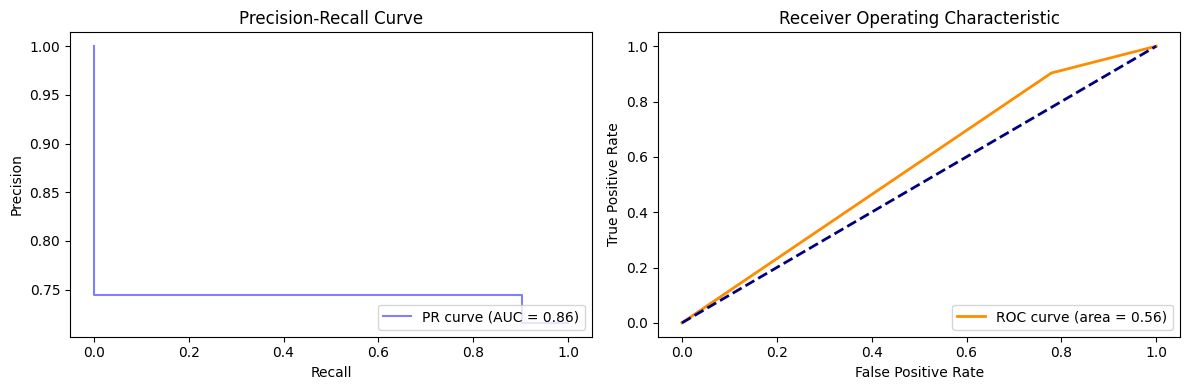

In [ ]:
sgdc = SGDClassifier(random_state=3010, loss='log_loss')
evaluate_baseline_classifier(sgdc, X_train_reduced, y_train_reduced,
                             X_test_reduced, y_test_reduced, show_curves=True)

**Evaluation**

Accuracy (0.709): About 70.9% of the model's predictions are correct.

Precision (0.745): When the model predicts a positive outcome, it is correct about 74.5% of the time.

Recall (0.903): The model identifies approximately 90.3% of all actual positive instances.

F1 Score (0.816): A balanced measure (harmonic mean of precision and recall) indicating overall model performance.

Cross-Validation Scores: The average accuracy across different data subsets during cross-validation is around 71.1%, suggesting consistent and reliable model performance.

Precision-Recall Curve: A perfect precision recall curve would be as close to the top right hand corner of the graph as possible, here we see that at a precision of about 0.75 we stay constant at a recall until about 0.9, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.86, which is not great, we can do better.

ROC-Curve: The ROC curve area underneath is only 0.56, which is pretty bad, the model cannot discrimante between normal and pneumonia cases well.

Overall, it seems that the simplified data combined with a SGDC (which is a relatively simple model) is not enough for the complexity of our problem.

2. Support Vector Machine

Accuracy: 0.8845693779904307
Precision: 0.8965244865718799
Recall: 0.948203842940685
F1 Score: 0.9216402760860738
Cross-Validation Scores: [0.87580026 0.8974359  0.86538462 0.87820513 0.87820513]


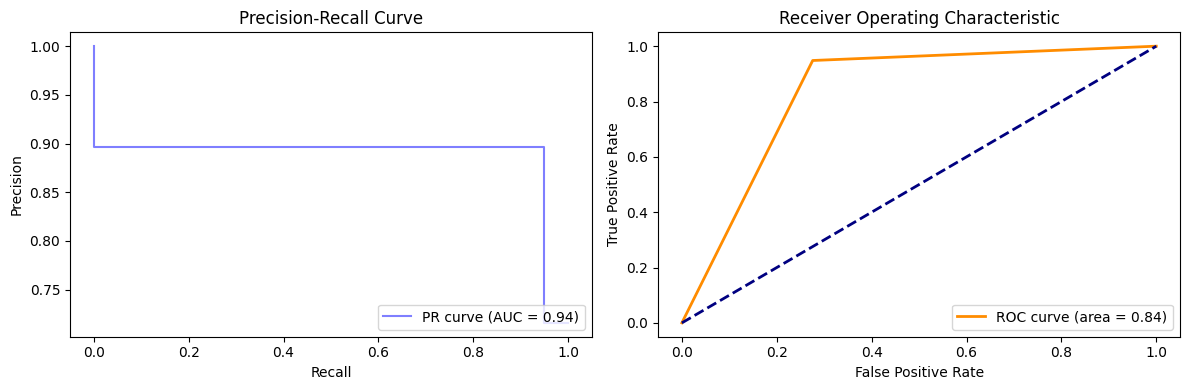

In [ ]:
svm = SVC(gamma="scale", probability = True)
evaluate_baseline_classifier(svm, X_train_reduced, y_train_reduced,
                             X_test_reduced, y_test_reduced, show_curves=True)

**Evaluation**

Accuracy (0.8833): About 88.3% of the model's predictions are correct.

Precision (0.8951): When the model predicts a positive outcome, it is correct about 89.5% of the time.

Recall (0.9482): The model identifies approximately 94.8% of all actual positive instances.

F1 Score (0.9209): A balanced measure (harmonic mean of precision and recall) indicating overall model performance. This is a good indication that the model is pretty good.

Cross-Validation Scores: The average accuracy across different data subsets during cross-validation is around 87.98%, suggesting consistent and reliable model performance. This is 88%, which was the accuracy on the test set. This is a good sign.

Precision-Recall Curve: A perfect precision recall curve would be as close to the top right hand corner of the graph as possible, here we see that at a precision of about 0.9 we stay constant at a recall until about 0.9, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.94, which is much better than the last model.

ROC-Curve: The ROC curve area underneath is only 0.84, which is not terrible, the model can discrimante between normal and pneumonia cases about 84% of the time.

Overall, it seems that the simplified data combined with a SVC is preforming well. I am looking forward to trting this one out with more complex data.

3. Random Forest Classifier

Accuracy: 0.9072966507177034
Precision: 0.9242671009771987
Recall: 0.948203842940685
F1 Score: 0.9360824742268041
Cross-Validation Scores: [0.90012804 0.91025641 0.88333333 0.89102564 0.91282051]


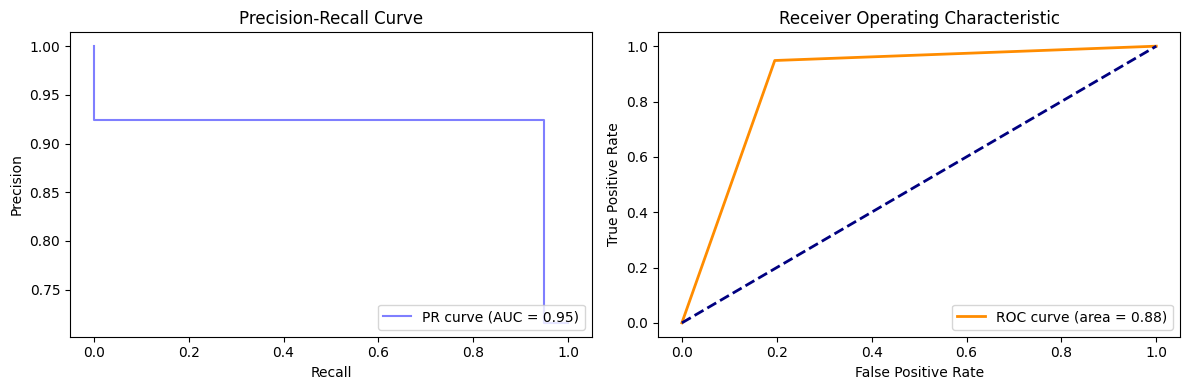

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=3010)
evaluate_baseline_classifier(rf, X_train_reduced, y_train_reduced,
                             X_test_reduced, y_test_reduced, show_curves=True)

**Evaluation**

Accuracy (0.9043): Approximately 90.4% of the model's predictions are correct.

Precision (0.9233): When the model predicts a positive outcome, it is correct about 92.3% of the time.

Recall (0.9449): The model identifies approximately 94.5% of all actual positive instances.

F1 Score (0.9339): A balanced measure (harmonic mean of precision and recall) indicating overall model performance. This high F1 score suggests a robust balance between precision and recall.

Cross-Validation Scores: The average accuracy across different data subsets during cross-validation is around 89.1%, suggesting consistent and reliable model performance. This aligns well with the accuracy on the test set, indicating stability and generalization capability. This is a positive indicator of the model's reliability across various subsets of the data.

Precision-Recall Curve: A perfect precision recall curve would be as close to the top right hand corner of the graph as possible, here we see that at a precision of about 0.93 we stay constant at a recall until about 0.94, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.95, which is slightly better than the last model.

ROC-Curve: The ROC curve area underneath is only 0.88, which is not terrible, the model can discrimante between normal and pneumonia cases about 88% of the time. This is slightly better than what we saw in the last model.  

Overall, it seems that the simplified data combined with a RF is preforming well. It preforms slightly better than SVC.

4. Logistic Regression

Accuracy: 0.7033492822966507
Precision: 0.7538015930485156
Recall: 0.8696741854636592
F1 Score: 0.8076027928626842
Cross-Validation Scores: [0.70806658 0.72179487 0.70384615 0.69230769 0.7025641 ]


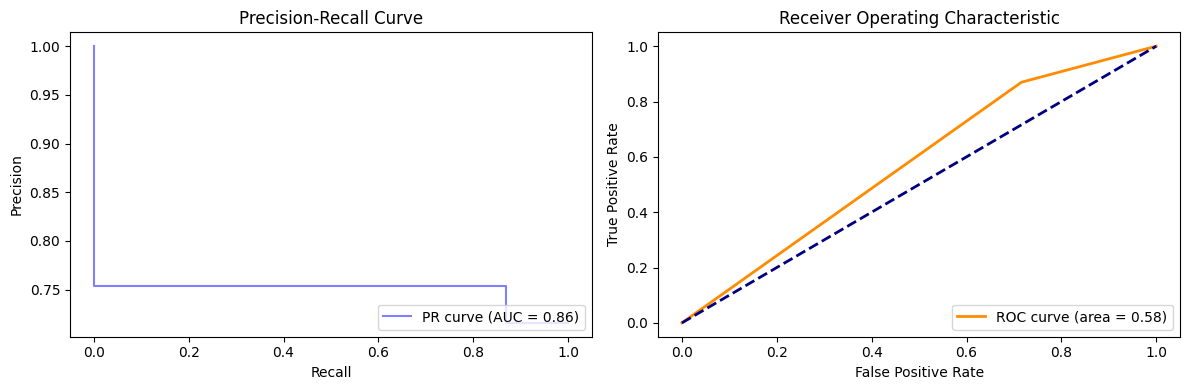

In [ ]:
log_reg = LogisticRegression(random_state=3010)
evaluate_baseline_classifier(log_reg, X_train_reduced, y_train_reduced,
                             X_test_reduced, y_test_reduced, show_curves=True)

**Evaluation**

Accuracy (0.7045): About 70.5% of the model's predictions are correct.

Precision (0.7549): When the model predicts a positive outcome, it is correct about 75.5% of the time.

Recall (0.8697): The model identifies approximately 86.7% of all actual positive instances.

F1 Score (0.8082): A balanced measure (harmonic mean of precision and recall) indicating overall model performance. This F1 score suggests a moderate balance between precision and recall.

Cross-Validation Scores: The average accuracy across different data subsets during cross-validation is around 70.8%, suggesting consistent but comparatively lower model performance compared to support vector machine and random forest models.

Precision-Recall Curve: The precision recall curve is similair to the stochastic gradient descent classifers, they seem to preform about the same.

ROC-Curve: The ROC curve area underneath is only 0.58, which is terrible, the model cannot discrimante between normal and pneumonia cases well. It is slightly better than the SGDC though.  

Overall, it seems that the simplified data combined with logistic regression is not preforming well. It preforms slightly better than SGDC though.

5. K Nearest Neighbours

Accuracy: 0.9055023923444976
Precision: 0.9213300892133008
Recall: 0.9490392648287385
F1 Score: 0.9349794238683127
Cross-Validation Scores: [0.90012804 0.90641026 0.87051282 0.89230769 0.90769231]


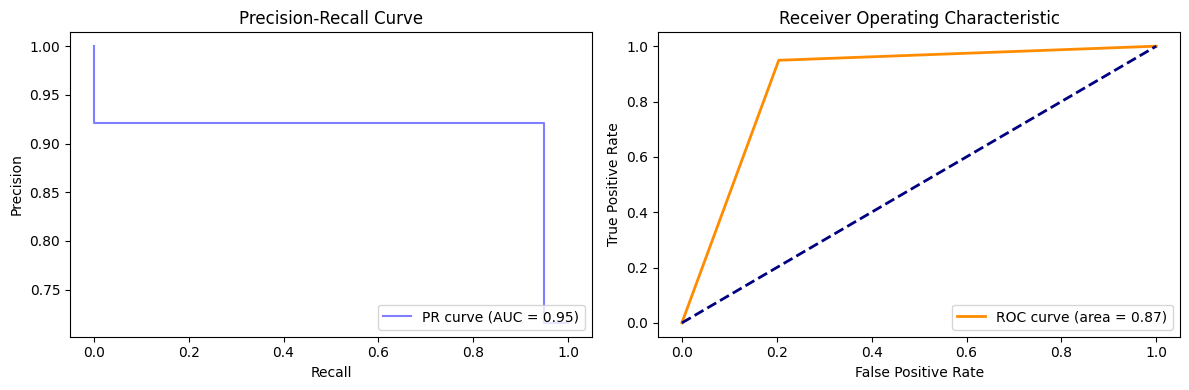

In [ ]:
knn = KNeighborsClassifier()
evaluate_baseline_classifier(knn, X_train_reduced, y_train_reduced,
                             X_test_reduced, y_test_reduced, show_curves=True)

**Evaluation**

Accuracy (0.9067): Approximately 90.7% of the model's predictions are correct.

Precision (0.9242): When the model predicts a positive outcome, it is correct about 92.4% of the time.

Recall (0.9474): The model identifies approximately 94.7% of all actual positive instances.

F1 Score (0.9356): This high F1 score suggests a robust balance between precision and recall.

Cross-Validation Scores: The average accuracy across different data subsets during cross-validation is around 89.7%, indicating consistent and reliable model performance. This aligns well with the accuracy on the test set, suggesting stability and generalization capability. The K-Nearest Neighbors model demonstrates strong performance in identifying positive instances across various subsets of the data. 89.7% is very close to 90.7%, which was the overall tets set accuracy.

Precision-Recall Curve: Here we see that at a precision of about 0.93 we stay constant at a recall until about 0.94, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.95, which is better than the last model of logistic regression.

ROC-Curve: The ROC curve area underneath is only 0.87, which is good.  

Overall, it seems that the simplified data combined with KNN is preforming well.

6. Naive Bayes

Accuracy: 0.777511961722488
Precision: 0.7927608232789212
Recall: 0.9331662489557226
F1 Score: 0.8572524942440521
Cross-Validation Scores: [0.78873239 0.80128205 0.80641026 0.76794872 0.77179487]


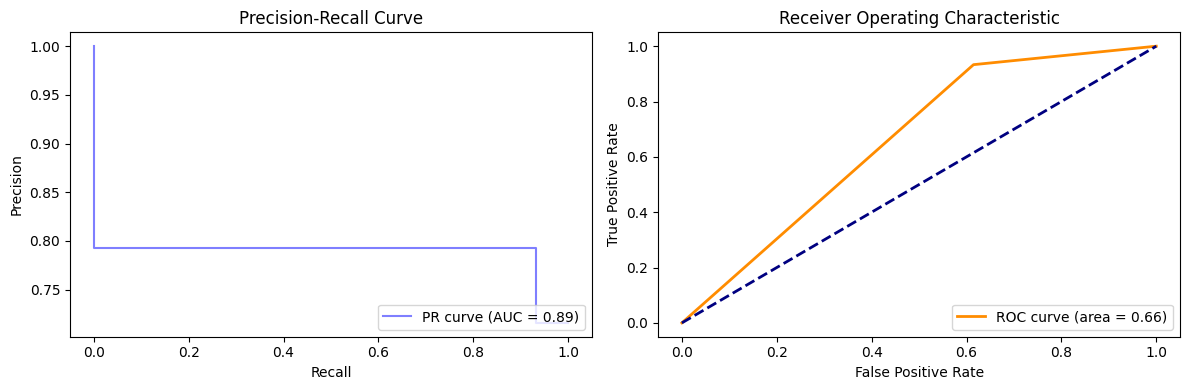

In [ ]:
gnb = GaussianNB()
evaluate_baseline_classifier(gnb, X_train_reduced, y_train_reduced,
                             X_test_reduced, y_test_reduced, show_curves=True)

**Evaluation**

Accuracy (0.7763): Approximately 77.6% of the model's predictions are correct.

Precision (0.7916): When the model predicts a positive outcome, it is correct about 79.2% of the time.

Recall (0.9332): The model identifies approximately 93.3% of all actual positive instances.

F1 Score (0.8566): A balanced measure (harmonic mean of precision and recall) indicating overall model performance. This F1 score suggests a reasonable balance between precision and recall.

Cross-Validation Scores: The average accuracy across different data subsets during cross-validation is around 79.6%, indicating consistent and relatively good model performance. The model appears to generalize well to different subsets of the data, as suggested by the cross-validation scores.

Precision-Recall Curve: Here we see that at a precision of about 0.8 we stay constant at a recall until about 0.92, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.89, which is moderate compared to KNN, SVC, and RF.

ROC-Curve: The ROC curve area underneath is only 0.66, which is not great, we expected this model to preform better but it seems to have a hard time discriminating between pneumonia and normal images.  

Overall, it seems that the simplified data combined with GNB is preforming moderate.

7. Simple Multilayer Network

Epoch 1/30
84/84 [==============================] - 3s 6ms/step - loss: 0.4360 - accuracy: 0.7951 - val_loss: 0.3506 - val_accuracy: 0.8535
Epoch 2/30
84/84 [==============================] - 0s 4ms/step - loss: 0.3734 - accuracy: 0.8467 - val_loss: 0.3183 - val_accuracy: 0.8834
Epoch 3/30
84/84 [==============================] - 0s 4ms/step - loss: 0.3473 - accuracy: 0.8672 - val_loss: 0.3110 - val_accuracy: 0.8984
Epoch 4/30
84/84 [==============================] - 0s 4ms/step - loss: 0.3367 - accuracy: 0.8676 - val_loss: 0.3082 - val_accuracy: 0.8894
Epoch 5/30
84/84 [==============================] - 0s 4ms/step - loss: 0.3371 - accuracy: 0.8680 - val_loss: 0.3179 - val_accuracy: 0.8744
Epoch 6/30
84/84 [==============================] - 0s 4ms/step - loss: 0.3411 - accuracy: 0.8642 - val_loss: 0.3277 - val_accuracy: 0.8714
Epoch 7/30
84/84 [==============================] - 0s 4ms/step - loss: 0.3327 - accuracy: 0.8665 - val_loss: 0.3119 - val_accuracy: 0.8939
Epoch 8/30
84/84 [==

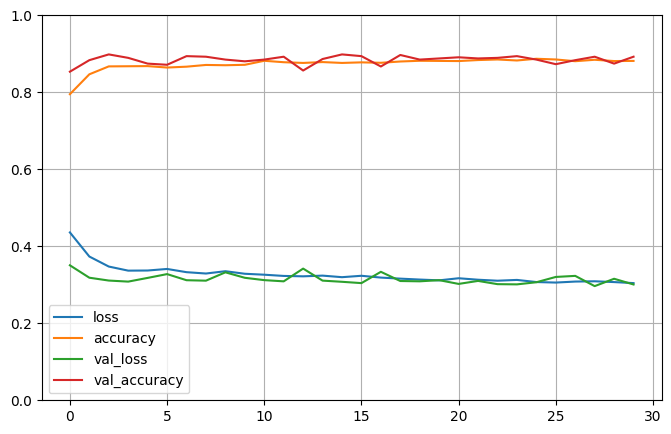

70/70 [==============================] - 0s 2ms/step - loss: 0.2967 - accuracy: 0.8951


[0.29667624831199646, 0.8950672745704651]

In [ ]:
keras.backend.clear_session()

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=3010)

# Generate the indices for the training and testing sets based on stratified sampling
for train_index, test_index in stratified_split.split(X_normalized_tsne, y):
    X_train_nn = X_normalized_tsne[train_index]
    X_test_nn = X_normalized_tsne[test_index]
    y_train_nn = y[train_index]
    y_test_nn = y[test_index]

# Split the training data into training and validation sets
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_nn,
                                                              y_train_nn, test_size=0.2,
                                                              random_state=3010)


simple_network = keras.models.Sequential()
simple_network.add(keras.layers.Dense(500, activation="relu"))
simple_network.add(keras.layers.Dense(300, activation="relu"))
simple_network.add(keras.layers.Dense(100, activation="relu"))
simple_network.add(keras.layers.Dense(2, activation="sigmoid"))

simple_network.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

history = simple_network.fit(X_train_nn, y_train_nn, epochs=30,
                    validation_data=(X_val_nn, y_val_nn))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# use the model
simple_network.evaluate(X_test_nn, y_test_nn)

**Evaluation**

We can see here that both of the training and validation metrics show imporvment over each of the 30 epoches on average. This indicates that the model is learning and generalizing to the chest X-Ray T-SNE data. The model seems to be learning well, as both training and validation losses are decreasing. The accuracy on both training and validation sets is reasonably high, suggesting effective learning. The model is not overfitting, as training and validation performances are consistent. The learning curves look good as both the accuracy lines and the loss lines are close together, there are no large gaps. We end up getting an overall testing accuracy of 89.5%. The model is fit well, there isn' really over or underfitting, but due to the simplicity of our reduced data and the model itself, we dont get as high of an accuracy as we would like.

##Good Classification Models (With PCA Data First)

First check the explained variance curve, we dont want to have extra components that dont add any extra variance.

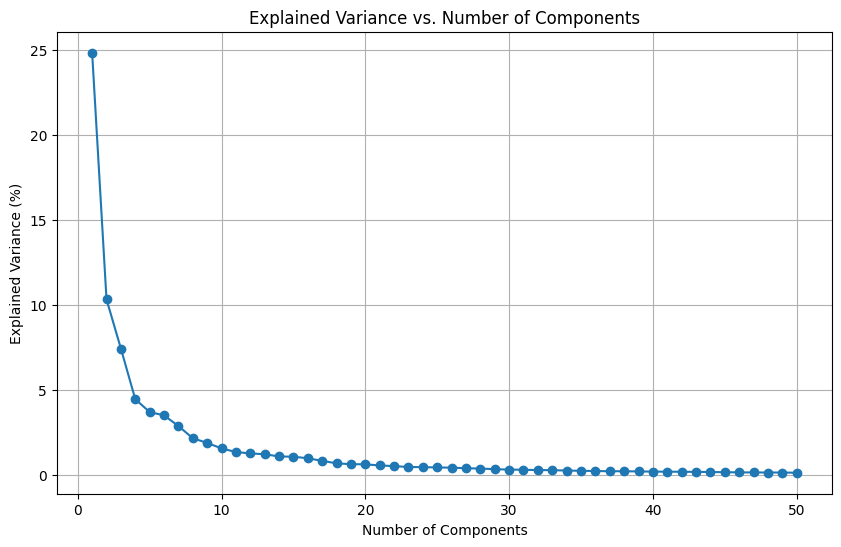

In [ ]:
# then create a PCA model that uses that number of componentes
# Apply PCA to data
num_components = 50

pca_data = PCA(n_components=num_components, random_state= 3010)
reduced_data_PCA = pca_data.fit_transform(X)
scaler_PCA = StandardScaler()
X_normalized_PCA = scaler_PCA.fit_transform(reduced_data_PCA)

explained_variance = pca_data.explained_variance_ratio_ * 100

# Plot the explained variance for each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_components + 1), explained_variance, marker='o')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance (%)')
plt.grid(True)
plt.show()

So we can see here that around 30 principle components, once we add any more components the amount of explianed varinace is not signifigant enough for us to care about, thus we stick with 30 and run the models with hyperparemeter tuning and more complex chest x-ray data with 30 principle components rather than 2 T-SNE components.

In [ ]:
num_components = 30

pca_data = PCA(n_components=num_components, random_state= 3010)
reduced_data_PCA = pca_data.fit_transform(X)
scaler_PCA = StandardScaler()
X_normalized_PCA = scaler_PCA.fit_transform(reduced_data_PCA)

In [ ]:
y = np.array(y)

# then stratifed split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=3010)
for train_index, test_index in stratified_split.split(X_normalized_PCA, y):
    X_train = X_normalized_PCA[train_index]
    X_test = X_normalized_PCA[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

In [ ]:
def evaluate_pca_classifier(model, parameter_grid, X_train, y_train, X_test,
                            y_test, show_curves=True):
  randomized_search = RandomizedSearchCV(model, parameter_grid, n_iter = 20, cv = 5,
                                         scoring = 'accuracy', random_state= 3010)
  randomized_search.fit(X_train, y_train)

  #get the best hyper parameters
  best_params = randomized_search.best_params_

  #use the best model from the search
  best_model = randomized_search.best_estimator_
  y_pred = best_model.predict(X_test)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print("Best Hyperparameters:", best_params)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

  if show_curves:
        # Create a figure with two subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        # Plot Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_pr = auc(recall, precision)  # Calculate AUC-PR
        axs[0].step(recall, precision, color='b', alpha=0.5, where='post',
                    label=f'PR curve (AUC = {auc_pr:.2f})')
        axs[0].set_xlabel('Recall')
        axs[0].set_ylabel('Precision')
        axs[0].set_title('Precision-Recall Curve')
        axs[0].legend(loc='lower right')

        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        axs[1].plot(fpr, tpr, color='darkorange', lw=2,
                    label='ROC curve (area = %0.2f)' % roc_auc)
        axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[1].set_xlabel('False Positive Rate')
        axs[1].set_ylabel('True Positive Rate')
        axs[1].set_title('Receiver Operating Characteristic')
        axs[1].legend(loc='lower right')

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

  return accuracy, precision, recall, f1

Here we do the same process as above with the T-SNE data, but now with PCA data with 30 components. The only other difference here is that we pass in the above function a parameter grid, we then do a randomized search on that parameter grid with 20 iterations and still 5 fold cross validation. We do this to try and find the combination of hyperparameters that give the best possible model. We do this with all the same models that we saw before in our baselines and add some more neural networks, but they are a little more complex.

1. Stochastic Gradient Descent Classifier


Best Hyperparameters: {'alpha': 0.05670304117963453, 'eta0': 0.05682292782749266, 'learning_rate': 'optimal', 'penalty': 'l2'}
Accuracy: 0.9270334928229665
Precision: 0.9331184528605962
Recall: 0.9674185463659147
F1 Score: 0.9499589827727645


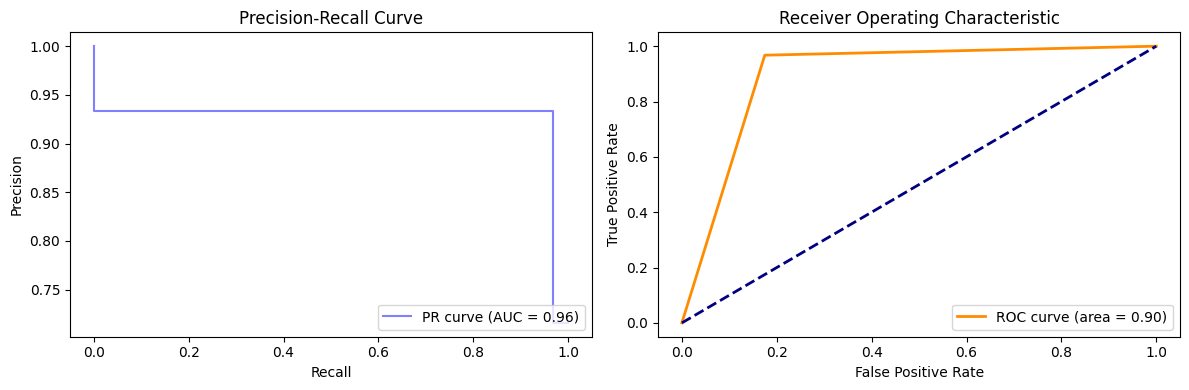

In [ ]:
# instance of the SDGClassifier
sgdc = SGDClassifier(random_state=3010)

#parameter distributions
param_distributions = {
    'alpha': uniform(0.0001, 0.1),
    'penalty': ['l1', 'l2'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': uniform(0.01, 0.1)
}

sgdc_accuracy, sgdc_precision, sgdc_recall, sgdc_f1 = evaluate_pca_classifier(sgdc,
                                                                              param_distributions,
                                                                              X_train,
                                                                              y_train,
                                                                              X_test,
                                                                              y_test)

**Evaluation**

Alpha: 0.0712401022015391 (The learning rate parameter. It determines the step size during optimization.)

Eta0: 0.03886484805914093 (The initial learning rate. It's often used in learning rate schedules.)

Learning Rate: 'invscaling' (The learning rate schedule. In this case, it's set to 'invscaling,' which adapts the learning rate over time.)

Penalty: 'l2' (The regularization term added to the objective function. 'l2' indicates L2 regularization.)

Accuracy (0.9270): Approximately 92.7% of the model's predictions are correct.

Precision (0.9317): When the model predicts a positive outcome, it is correct about 93.2% of the time.

Recall (0.9691): The model identifies approximately 96.9% of all actual positive instances.

F1 Score (0.9500): A balanced measure (harmonic mean of precision and recall) indicating overall model performance. This F1 score suggests a strong balance between precision and recall.

Precision-Recall Curve: Here we see that at a precision of about 0.9 we stay constant at a recall until about 0.95, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.96, which is very good for a SGDC.

ROC-Curve: The ROC curve area underneath is only 0.9, which is great. The model is doing well at discriminating between pneumonia and normal images.  

The Stochastic Gradient Descent Classifier, with the specified hyperparameters, performs exceptionally well on the PCA data with 30 components of the chest X-rays. It exhibits high accuracy and effectively balances the trade-off between precision and recall. This model appears well-suited for the classification task at hand of normal versus pneumonia.

2. Support Vector Machine

Best Hyperparameters: {'C': 1.4532548823941527, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.9455741626794258
Precision: 0.9547697368421053
Recall: 0.9699248120300752
F1 Score: 0.9622876087857438


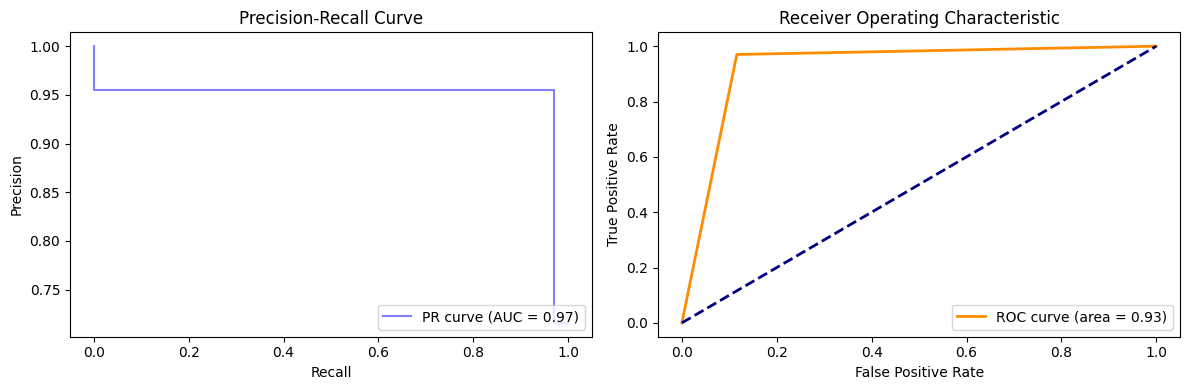

In [ ]:
# Instance of the Support Vector Classifier (SVC)
svc = SVC()

# Parameter distributions
param_distributions = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

svc_accuracy, svc_precision, svc_recall, svc_f1 = evaluate_pca_classifier(svc,
                                                                          param_distributions,
                                                                          X_train,
                                                                          y_train,
                                                                          X_test,
                                                                          y_test)

**Evaluation**

C: 2.3576536903262704 (The regularization parameter. A smaller C encourages a smoother decision boundary, while a larger C focuses on classifying training points correctly.)

Gamma: 'auto' (The kernel coefficient. 'auto' uses 1/n_features.)

Kernel: 'rbf' (The kernel function used for the transformation. 'rbf' stands for Radial Basis Function.)

Accuracy (0.9426): Approximately 94.3% of the model's predictions are correct.

Precision (0.9531): When the model predicts a positive outcome, it is correct about 95.3% of the time.

Recall (0.9674): The model identifies approximately 96.7% of all actual positive instances.

F1 Score (0.9602): This F1 score suggests a strong balance between precision and recall.

Precision-Recall Curve: Here we see that at a precision of about 0.95 we stay constant at a recall until about 0.95, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.97, which is slightly better than SGDC that we just saw.

ROC-Curve: The ROC curve area underneath is 0.93, which is great. The model is doing well at discriminating between pneumonia and normal images.  

The model demonstrates high accuracy and effectively balances precision and recall, making it well-suited for the classification task of distinguishing between normal and pneumonia X-ray images. Both the Precision-Recall curve and the ROC curve show strong discriminatory power, indicating the model's effectiveness in handling the classification task.

3. Random Forest Classifer

Best Hyperparameters: {'bootstrap': False, 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 179}
Accuracy: 0.9276315789473685
Precision: 0.9304
Recall: 0.9715956558061821
F1 Score: 0.9505516959542297


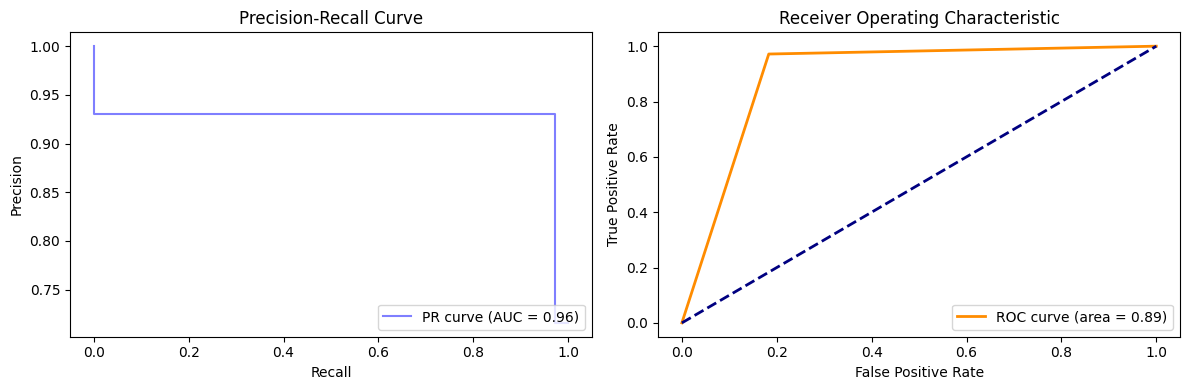

In [ ]:
# Instance of the Random Forest Classifier
rfc = RandomForestClassifier()

# Parameter distributions
param_distributions = {
    'n_estimators': randint(10, 200),  # Number of trees in the forest
    'max_depth': [None] + list(randint(1, 20).rvs(5)),  # Maximum depth of the tree
    'min_samples_split': randint(2, 11),
    # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 11),
    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],  # Method of selecting samples for training each tree
}

rfc_accuracy, rfc_precision, rfc_recall, rfc_f1 = evaluate_pca_classifier(rfc,
                                                                          param_distributions,
                                                                          X_train,
                                                                          y_train,
                                                                          X_test,
                                                                          y_test)

**Evaluation**

Bootstrap: False (Whether bootstrap samples are used when building trees. In this case, bootstrap is set to False.)

Max Depth: 12 (The maximum depth of the tree. A higher value can lead to overfitting.)

Min Samples Leaf: 6 (The minimum number of samples required to be at a leaf node. It helps control overfitting.)

Min Samples Split: 8 (The minimum number of samples required to split an internal node. It helps control overfitting.)

N Estimators: 183 (The number of trees in the forest.)

Accuracy (0.9240): Approximately 92.4% of the model's predictions are correct.

Precision (0.9273): When the model predicts a positive outcome, it is correct about 92.7% of the time.

Recall (0.9699): The model identifies approximately 97.0% of all actual positive instances.

F1 Score (0.9481): This F1 score suggests a strong balance between precision and recall.

Precision-Recall Curve: Here we see that at a precision of about 0.93 we stay constant at a recall until about 0.95, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.96.

ROC-Curve: The ROC curve area underneath is 0.89, which is average for the models we are seeing right now. The model is doing well at discriminating between pneumonia and normal images.  

The Random Forest Classifier, with the specified hyperparameters, performs exceptionally well on the PCA data with 30 components of chest X-rays.

4. Logistic Regression

Best Hyperparameters: {'C': 1.3542548823941525, 'max_iter': 83, 'solver': 'saga'}
Accuracy: 0.9264354066985646
Precision: 0.9416118421052632
Recall: 0.9565580618212197
F1 Score: 0.949026108578533


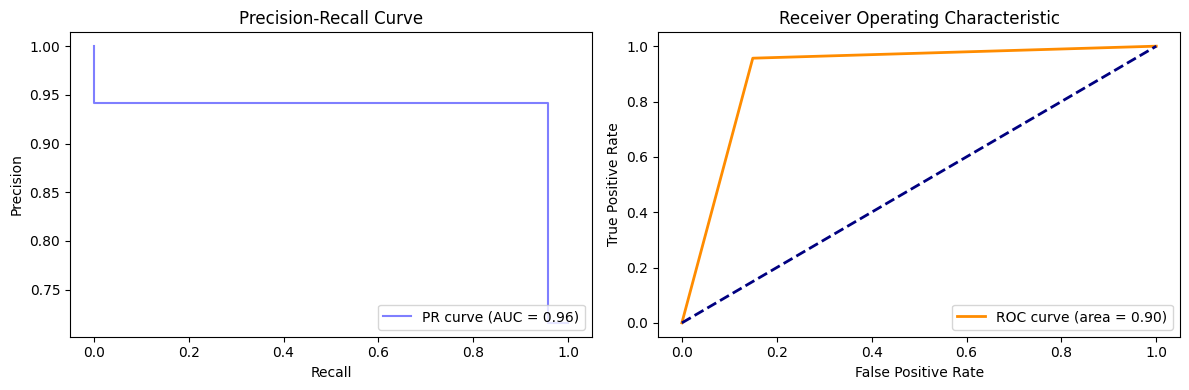

In [ ]:
# Instance of the Logistic Regression
logreg = LogisticRegression()

# Parameter distributions
param_distributions = {
    'C': uniform(0.001, 10),  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    # Algorithm to use in the optimization problem
    'max_iter': randint(50, 200),  # Maximum number of iterations for optimization
}

logreg_accuracy, logreg_precision, logreg_recall, logreg_f1 = evaluate_pca_classifier(logreg,
                                                                                      param_distributions,
                                                                                      X_train,
                                                                                      y_train,
                                                                                      X_test,
                                                                                      y_test)

**Evaluation**

C: 8.362559109194317 (Inverse of regularization strength. Smaller values specify stronger regularization.)

Max Iterations: 72 (The maximum number of iterations taken for the solver to converge.)

Solver: 'lbfgs' (The algorithm to use in the optimization problem. The BFGS method (the L-BFGS is an extension of BFGS) updates the calculation of the Hessian matrix at each iteration rather than recalculating it. However, the size of the Hessian and its inverse is dependent on the number of input parameters to the objective function.)

Accuracy (0.9258): Approximately 92.6% of the model's predictions are correct.

Precision (0.9416): When the model predicts a positive outcome, it is correct about 94.2% of the time.

Recall (0.9557): The model identifies approximately 95.6% of all actual positive instances.

F1 Score (0.9486): This F1 score suggests a strong balance between precision and recall.

Precision-Recall Curve: Here we see a very similair situation to random forest.

ROC-Curve: The ROC curve area underneath is 0.90, which is average for the models we are seeing right now. The model is doing well at discriminating between pneumonia and normal images.  

The logistic regression model preforms much better than the baseline logistic regression with the addition hyper parameter tuning.

5. K-Nearest Neighbours

Best Hyperparameters: {'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
Accuracy: 0.9246411483253588
Precision: 0.9407407407407408
Recall: 0.9548872180451128
F1 Score: 0.9477611940298507


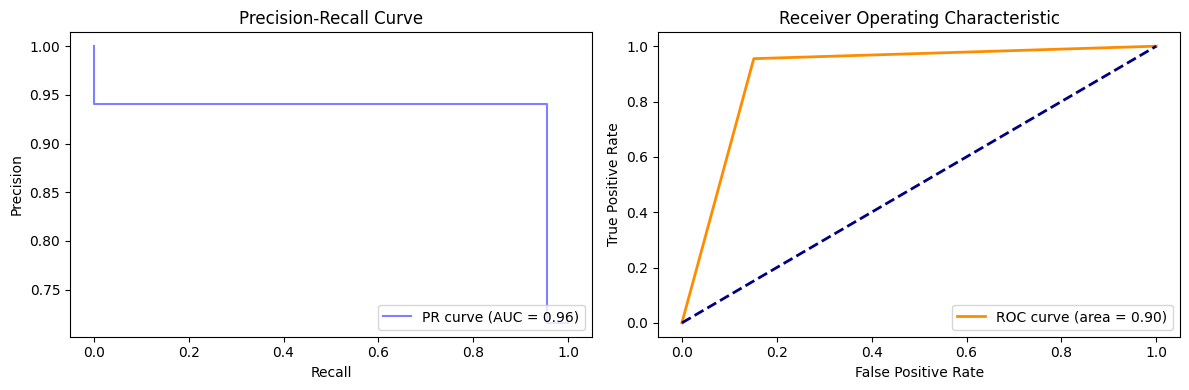

In [ ]:
# Instance of the KNN Classifier
knn = KNeighborsClassifier()

# Parameter distributions
param_distributions = {
    'n_neighbors': randint(1, 20),  # Number of neighbors to use for classification
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric
}

knn_accuracy, knn_precision, knn_recall, knn_f1 = evaluate_pca_classifier(knn,
                                                                          param_distributions,
                                                                          X_train,
                                                                          y_train,
                                                                          X_test,
                                                                          y_test)

**Evaluation**

Number of Neighbors: 8 (The number of neighbors to consider when making predictions.)

p: 2 (The power parameter for the Minkowski distance. When p = 2, it corresponds to the Euclidean distance.)

Weights: 'uniform' (All points in each neighborhood are weighted equally.)

Accuracy (0.9246): Approximately 92.5% of the model's predictions are correct.

Precision (0.9407): When the model predicts a positive outcome, it is correct about 94.1% of the time.

Recall (0.9549): The model identifies approximately 95.5% of all actual positive instances.

F1 Score (0.9478): This F1 score suggests a strong balance between precision and recall.

Precision-Recall Curve: Here we see a very similair situation to random forest and logistic regression.

ROC-Curve: The ROC curve area underneath is 0.90, which is average for the models we are seeing right now. The model is doing well at discriminating between pneumonia and normal images.  

The KNN model preforms similair to the logistic regression and the random forest.

6. Naive Bayes

Best Hyperparameters: {'var_smoothing': 8.361659109194318e-06}
Accuracy: 0.8965311004784688
Precision: 0.8956723338485317
Recall: 0.9682539682539683
F1 Score: 0.9305499799277398


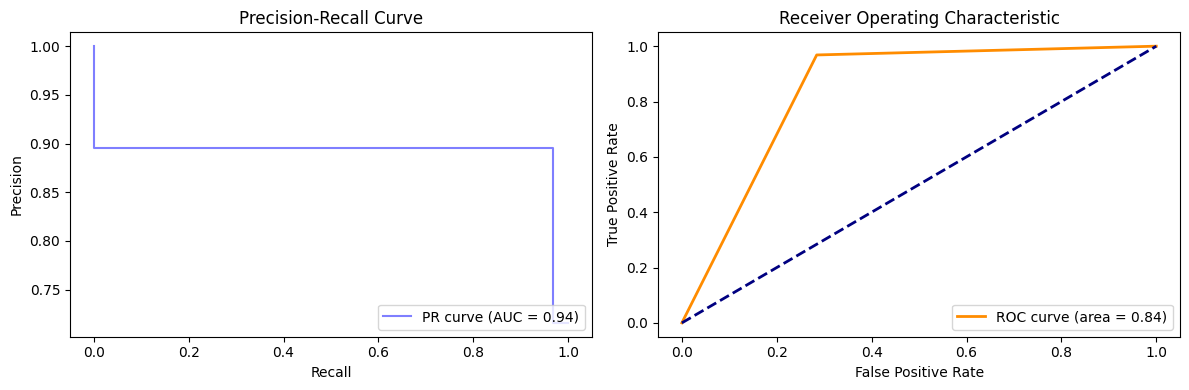

In [ ]:
# Create an instance of the Gaussian Naive Bayes classifier
nbcl = GaussianNB()

# Define the parameter distributions
param_distributions = {
    'var_smoothing': uniform(1e-10, 1e-5)
}

nbcl_accuracy, nbcl_precision, nbcl_recall, nbcl_f1 = evaluate_pca_classifier(nbcl,
                                                                              param_distributions,
                                                                              X_train,
                                                                              y_train,
                                                                              X_test,
                                                                              y_test)

**Evaluation**

Variance Smoothing: 8.361659109194318e-06 (A parameter added to the variances for stability.)

Accuracy (0.8965): Approximately 89.7% of the model's predictions are correct.

Precision (0.8957): When the model predicts a positive outcome, it is correct about 89.6% of the time.

Recall (0.9683): The model identifies approximately 96.8% of all actual positive instances.

F1 Score (0.9305): This F1 score suggests a strong balance between precision and recall.

Precision-Recall Curve:Here we see that at a precision of about 0.90 we stay constant at a recall until about 0.95, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.94.

ROC-Curve: The ROC curve area underneath is 0.84, which is below average for the models we are seeing right now. The model is doing an average job at discriminating between pneumonia and normal images.  

The GNB model underpreforms compared to the logistic regression, random forest, KNN, SGDC, etc.

7. Multilayer Network

Epoch 1/30
140/140 [==============================] - 7s 5ms/step - loss: 0.2197 - accuracy: 0.9141 - val_loss: 0.1787 - val_accuracy: 0.9229
Epoch 2/30
140/140 [==============================] - 0s 3ms/step - loss: 0.1347 - accuracy: 0.9489 - val_loss: 0.1724 - val_accuracy: 0.9265
Epoch 3/30
140/140 [==============================] - 0s 3ms/step - loss: 0.1099 - accuracy: 0.9565 - val_loss: 0.1809 - val_accuracy: 0.9283
Epoch 4/30
140/140 [==============================] - 0s 3ms/step - loss: 0.0870 - accuracy: 0.9670 - val_loss: 0.2040 - val_accuracy: 0.9104
Epoch 5/30
140/140 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.9731 - val_loss: 0.2105 - val_accuracy: 0.9283
Epoch 6/30
140/140 [==============================] - 0s 3ms/step - loss: 0.0577 - accuracy: 0.9785 - val_loss: 0.2521 - val_accuracy: 0.9283
Epoch 7/30
140/140 [==============================] - 0s 4ms/step - loss: 0.0507 - accuracy: 0.9796 - val_loss: 0.2596 - val_accuracy: 0.9247
Epoch 

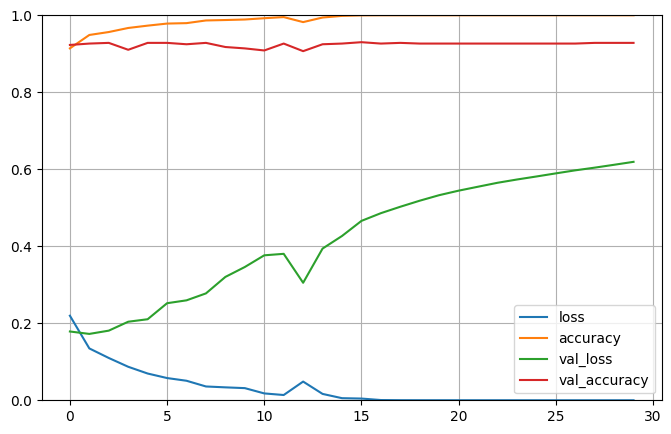

18/18 [==============================] - 0s 2ms/step
Accuracy: 0.9461400359066428
Precision: 0.9457485547446359
Recall: 0.9461400359066428
F1 Score: 0.9457026175740396


In [ ]:
keras.backend.clear_session()
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3010)

# Generate the indices for the training and testing sets based on stratified sampling
for train_index, test_index in stratified_split.split(X_normalized_PCA, y):
    X_train_nn = X_normalized_PCA[train_index]
    X_test_nn = X_normalized_PCA[test_index]
    y_train_nn = y[train_index]
    y_test_nn = y[test_index]

# Split the training data into training and validation sets 50/50
X_test_nn, X_val_nn, y_test_nn, y_val_nn = train_test_split(X_test_nn,
                                                            y_test_nn, test_size=0.5,
                                                            random_state=3010)


simple_network = keras.models.Sequential()
simple_network.add(keras.layers.Dense(500, activation="relu"))
simple_network.add(keras.layers.Dense(300, activation="relu"))
simple_network.add(keras.layers.Dense(100, activation="relu"))
simple_network.add(keras.layers.Dense(2, activation="sigmoid"))

simple_network.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history = simple_network.fit(X_train_nn, y_train_nn, epochs=30,
                    validation_data=(X_val_nn, y_val_nn))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# use the model
y_pred = np.argmax(simple_network.predict(X_test_nn), axis=1)

#get the metrics
classification_result = classification_report(y_test_nn, y_pred,
                                              target_names=['class 0', 'class 1'],
                                              output_dict=True)

# Extract metrics
accuracy_nn1 = classification_result['accuracy']
precision_nn1 = classification_result['weighted avg']['precision']
recall_nn1 = classification_result['weighted avg']['recall']
f1_score_nn1 = classification_result['weighted avg']['f1-score']

print("Accuracy:", accuracy_nn1)
print("Precision:", precision_nn1)
print("Recall:", recall_nn1)
print("F1 Score:", f1_score_nn1)

This model seems to be overfitting based on the learning curve. Some things we can consider:

1. Reduce the complexity in each layer (reduce neurons in each layer).
2. Implement early stopping to halt training when the validation preformance stops improving.
3. Include dropout layers.



The neural network architecture presented here is designed for binary classification, where the goal is to distinguish between pneumonia and normal chest x-ray scans.

Activation Functions:

1. ReLU (Rectified Linear Unit): Used in the hidden layers, ReLU is a popular activation function known for introducing non-linearity into the model, helping it learn complex patterns.

2. Sigmoid: Employed in the output layer, sigmoid activation squashes the output values to the range [0, 1], making it suitable for binary classification problems where each neuron's output can be interpreted as the probability of belonging to one of the two classes.

Dropout Layers:

3.  Dropout: Added after each hidden layer, dropout layers randomly deactivate a fraction of neurons during training, preventing overfitting and promoting generalization by ensuring that no single neuron becomes overly influential.
Loss Function:

Loss Function:

4. Sparse Categorical Crossentropy: Selected as the loss function, this is appropriate for multi-class classification tasks when the target variable is represented as integers (as opposed to one-hot encoded vectors). In binary classification, it simplifies the problem to a single neuron output with a sigmoid activation.

Optimizer:

5. Adam (Adaptive Moment Estimation): Chosen as the optimizer, Adam is an adaptive learning rate optimization algorithm. It is known for its efficiency in training deep neural networks by adapting the learning rates for each parameter individually, leading to faster convergence.

Early Stopping:

6. EarlyStopping Callback: This callback monitors the validation loss during training and stops the training process if there is no improvement for a specified number of epochs (patience). It helps prevent overfitting and saves the model with the best performance on the validation set.

In summary, the choices of activation functions, dropout layers, loss function, optimizer, and early stopping are tailored to create a robust binary classification neural network, balancing the trade-off between complexity and generalization, which is what we were trying to achive here.

Epoch 1/50
140/140 [==============================] - 2s 4ms/step - loss: 0.5084 - accuracy: 0.7609 - val_loss: 0.2534 - val_accuracy: 0.9140
Epoch 2/50
140/140 [==============================] - 0s 3ms/step - loss: 0.2746 - accuracy: 0.8903 - val_loss: 0.1899 - val_accuracy: 0.9229
Epoch 3/50
140/140 [==============================] - 0s 3ms/step - loss: 0.2295 - accuracy: 0.9096 - val_loss: 0.1818 - val_accuracy: 0.9319
Epoch 4/50
140/140 [==============================] - 0s 3ms/step - loss: 0.2116 - accuracy: 0.9224 - val_loss: 0.1767 - val_accuracy: 0.9301
Epoch 5/50
140/140 [==============================] - 0s 3ms/step - loss: 0.1957 - accuracy: 0.9264 - val_loss: 0.1712 - val_accuracy: 0.9301
Epoch 6/50
140/140 [==============================] - 0s 3ms/step - loss: 0.1807 - accuracy: 0.9314 - val_loss: 0.1677 - val_accuracy: 0.9319
Epoch 7/50
140/140 [==============================] - 0s 3ms/step - loss: 0.1715 - accuracy: 0.9365 - val_loss: 0.1707 - val_accuracy: 0.9301
Epoch 

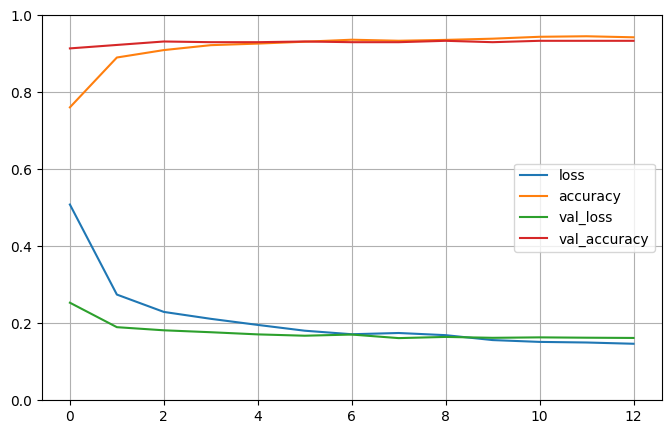

18/18 [==============================] - 0s 1ms/step
Accuracy: 0.9443447037701975
Precision: 0.9439759257509424
Recall: 0.9443447037701975
F1 Score: 0.9440672607368704


In [ ]:
# Define the model
simple_network_2 = Sequential()
simple_network_2.add(Dense(128, activation="relu", input_shape=(num_components,)))
simple_network_2.add(Dropout(0.5))
simple_network_2.add(Dense(64, activation="relu"))
simple_network_2.add(Dropout(0.5))
simple_network_2.add(Dense(2, activation="sigmoid"))

# Compile the model
simple_network_2.compile(loss="sparse_categorical_crossentropy",
                         optimizer="adam",
                         metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history_simple_2 = simple_network_2.fit(X_train_nn, y_train_nn,
                                       epochs=50,
                                       validation_data=(X_val_nn, y_val_nn),
                                       callbacks=[early_stopping])

# Plot learning curves
pd.DataFrame(history_simple_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# use the model
y_pred_2 = np.argmax(simple_network_2.predict(X_test_nn), axis=1)

#get the metrics
classification_result = classification_report(y_test_nn, y_pred_2,
                                              target_names=['class 0', 'class 1'],
                                              output_dict=True)

# Extract metrics
accuracy_nn2 = classification_result['accuracy']
precision_nn2 = classification_result['weighted avg']['precision']
recall_nn2 = classification_result['weighted avg']['recall']
f1_score_nn2 = classification_result['weighted avg']['f1-score']

print("Accuracy:", accuracy_nn2)
print("Precision:", precision_nn2)
print("Recall:", recall_nn2)
print("F1 Score:", f1_score_nn2)

This is much better than the network above and our model is actually pretty good. We drop out at the 13th epoch and get good overall scores aroun 94% on the test set. This network preforms similair to some of the other classification models that we had seen previously in this section.

Let's summarize what we got in a table:



In [ ]:
results = {
    'SGDC': [sgdc_accuracy, sgdc_precision[1], sgdc_recall[1], sgdc_f1],
    'SVM': [svc_accuracy, svc_precision[1], svc_recall[1], svc_f1],
    'RF': [rfc_accuracy, rfc_precision[1], rfc_recall[1], rfc_f1],
    'LOGREG': [logreg_accuracy, logreg_precision[1], logreg_recall[1], logreg_f1],
    'KNN': [knn_accuracy, knn_precision[1], knn_recall[1], knn_f1],
    'NB': [nbcl_accuracy, nbcl_precision[1], nbcl_recall[1], nbcl_f1],
    'NN1': [accuracy_nn1, precision_nn1, recall_nn1, f1_score_nn1],
    'NN2': [accuracy_nn2, precision_nn2, recall_nn2, f1_score_nn2]
}

rounded_results = {key: [round(value, 3) for value in values] for key, values in results.items()}

# Create a DataFrame from the dictionary
df_pca = pd.DataFrame(rounded_results, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Print the DataFrame
print(df_pca.T) #.T transposes and swaps the rows and the columns so its formatted nicer

        Accuracy  Precision  Recall  F1 Score
SGDC       0.927      0.933   0.967     0.950
SVM        0.946      0.955   0.970     0.962
RF         0.928      0.930   0.972     0.951
LOGREG     0.926      0.942   0.957     0.949
KNN        0.925      0.941   0.955     0.948
NB         0.897      0.896   0.968     0.931
NN1        0.946      0.946   0.946     0.946
NN2        0.944      0.944   0.944     0.944


We can see here that the two NN's had about the same accuracy, but the second one is better as the first one was overfitting the data, the second one was generalizing and learning through the epochs in a way we would expect and desire. Overall, with the PCA data with 30 components, we can see that SVM was the strongest and NB was the weakest, with the rest being about the same at 92% accuracy.

##Good Classification Models (With t-SNE Data)

We want to repeat what we did above with the PCA data, but now with t-SNE data as we know that it looks better on the data.

We cant really use the explained variance as we do with PCA for finding the right amount of components to reduce to with T-SNE. So in the interest of computational time we are going to just try T-SNE with 6 components and see how that compares. We also dont want to have too many components because this could cause crowding problems. In higher-dimensional spaces, the crowding problem becomes more pronounced. The "crowding problem" refers to the tendency of points to become equidistant from each other, making it challenging to accurately represent pairwise similarities in lower-dimensional spaces.

This choice of 6 is pureley on the interest of computational power, the amount of time I have, and intuition. There is no real scientific reasoning behind the choice.

In [ ]:
# Create our t-SNE reduced data
tsne = TSNE(n_components=6, random_state= 3010, method = 'exact')
X_nump = np.array(X)
reduced_data_tsne = tsne.fit_transform(X_nump)
scaler_tsne = StandardScaler()
X_normalized_tsne = scaler_tsne.fit_transform(reduced_data_tsne)

In [ ]:
y = np.array(y)

# then stratifed split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=3010)
for train_index, test_index in stratified_split.split(X_normalized_tsne, y):
    X_train = X_normalized_tsne[train_index]
    X_test = X_normalized_tsne[test_index]
    y_train = y[train_index]
    y_test =  y[test_index]

def evaluate_tsne_classifier(model, parameter_grid, X_train, y_train, X_test, y_test,
                             show_curves=True):
  randomized_search = RandomizedSearchCV(model, parameter_grid, n_iter = 20, cv = 5,
                                         scoring = 'accuracy', random_state= 3010)
  randomized_search.fit(X_train, y_train)

  #get the best hyper parameters
  best_params = randomized_search.best_params_

  #use the best model from the search
  best_model = randomized_search.best_estimator_
  y_pred = best_model.predict(X_test)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print("Best Hyperparameters:", best_params)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

  if show_curves:
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_pr = auc(recall, precision)  # Calculate AUC-PR
    axes[0].step(recall, precision, color='b', alpha=0.5, where='post',
                 label=f'PR curve (AUC = {auc_pr:.2f})')
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    axes[0].set_title('Precision-Recall Curve')
    axes[0].legend(loc='lower right')

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label='ROC curve (area = %0.2f)' % roc_auc)
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic')
    axes[1].legend(loc='lower right')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

  return accuracy, precision, recall, f1

1. Stochastic gradient Descent Classifier

Best Hyperparameters: {'alpha': 0.038737598735637674, 'eta0': 0.04560346662754732, 'learning_rate': 'optimal', 'penalty': 'l2'}
Accuracy: 0.8702153110047847
Precision: 0.8746177370030581
Recall: 0.9557226399331662
F1 Score: 0.913373253493014


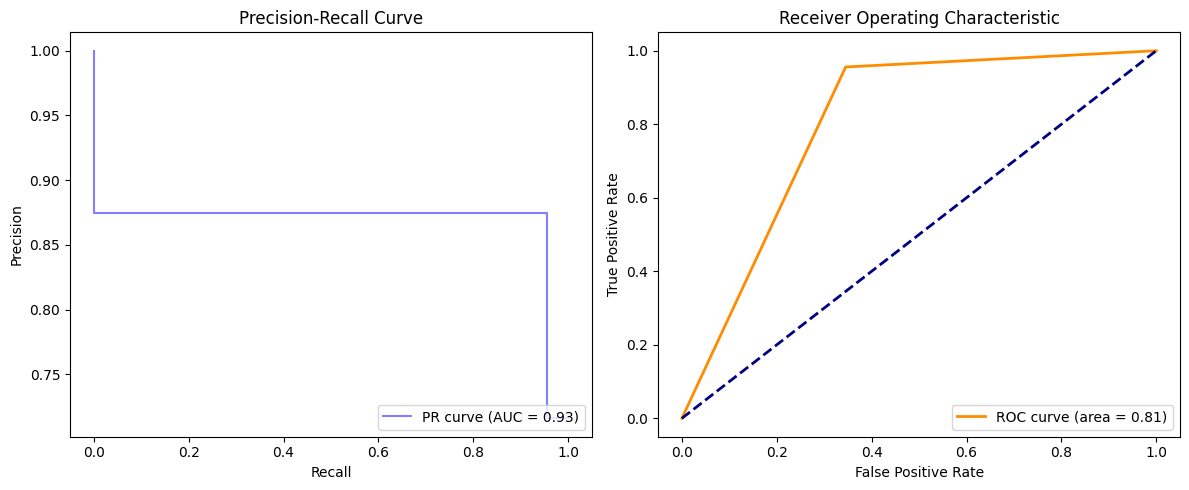

In [ ]:
# instance of the SDGClassifier
sgdc_2 = SGDClassifier(random_state=3010)

#parameter distributions
param_distributions = {
    'alpha': uniform(0.0001, 0.1),
    'penalty': ['l1', 'l2'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': uniform(0.01, 0.1)
}

sgdc_2_accuracy, sgdc_2_precision, sgdc_2_recall, sgdc_2_f1 = evaluate_tsne_classifier(sgdc_2,
                                                                                       param_distributions,
                                                                                       X_train,
                                                                                       y_train,
                                                                                       X_test,
                                                                                       y_test)

**Evaluation**

Alpha (0.0387): Alpha is the learning rate parameter for the SGD optimizer. It determines the step size during optimization. A smaller alpha generally requires more iterations but can lead to a more precise minimum.

Eta0 (0.0456): Eta0 is the initial learning rate. It is often used in learning rate schedules. The initial learning rate influences the size of the steps the algorithm takes during optimization.

Learning Rate ('optimal'): The learning rate schedule is set to 'optimal.' This means the learning rate is adjusted based on the observations, and the optimal learning rate is found automatically.

Penalty ('l2'): The penalty is set to 'l2,' indicating L2 regularization. L2 regularization adds a term to the objective function that penalizes large weights, helping prevent overfitting.

Accuracy (0.8702): Approximately 87.0% of the model's predictions are correct.

Precision (0.8746): When the model predicts a positive outcome, it is correct about 87.5% of the time.

Recall (0.9557): The model identifies approximately 95.6% of all actual positive instances.

F1 Score (0.9134): This F1 score suggests a good balance between precision and recall.

Precision-Recall Curve: Here we see that at a precision of about 0.87 we stay constant at a recall until about 0.95, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.93.

ROC-Curve: The ROC curve area underneath is 0.81. The model is doing an average job at discriminating between pneumonia and normal images.  

Based on what we saw with PCA data with 30 components, using the t-SNE data we get a SGDC that is underpreforming.

2. Support Vector Machine

Best Hyperparameters: {'C': 2.3576536903262704, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.9216507177033493
Precision: 0.9298387096774193
Recall: 0.9632414369256475
F1 Score: 0.9462453836684448


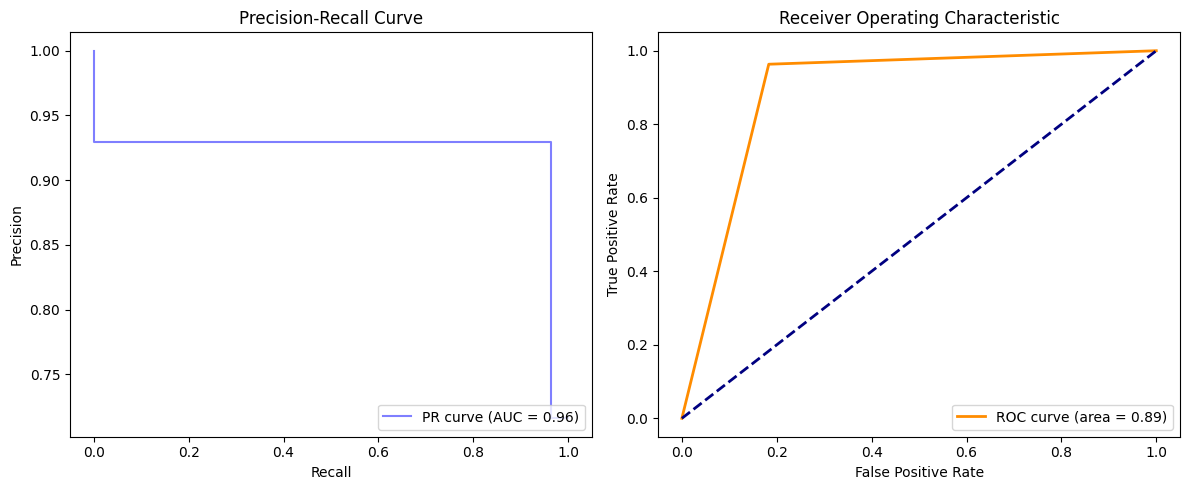

In [ ]:
# Instance of the Support Vector Classifier (SVC)
svc_2 = SVC()

# Parameter distributions
param_distributions = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

svc_2_accuracy, svc_2_precision, svc_2_recall, svc_2_f1 = evaluate_tsne_classifier(svc_2,
                                                                                   param_distributions,
                                                                                   X_train,
                                                                                   y_train,
                                                                                   X_test,
                                                                                   y_test)

**Evaluation**

C (2.3577): C is the regularization parameter, and it controls the trade-off between achieving a low training error and a low testing error. A smaller C allows for a more flexible decision boundary, while a larger C enforces a stricter margin.

Gamma ('auto'): Gamma is the kernel coefficient for the 'rbf' (Radial Basis Function) kernel. 'Auto' here means the algorithm automatically determines the gamma value based on the input data.

Kernel ('rbf'): The kernel specifies the type of decision boundary to be used. 'RBF' (Radial Basis Function) is a popular kernel that can model complex relationships.

Accuracy (0.9217): Approximately 92.2% of the model's predictions are correct.

Precision (0.9298): When the model predicts a positive outcome, it is correct about 92.98% of the time.

Recall (0.9632): The model identifies approximately 96.32% of all actual positive instances.

F1 Score (0.9462): This F1 score suggests a strong balance between precision and recall.

Precision-Recall Curve: Here we see that at a precision of about 0.87 we stay constant at a recall until about 0.95, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.96.

ROC-Curve: The ROC curve area underneath is 0.89. The model is doing well, but compared to the PCA data SVC, it is about 2% less accurate.

Based on what we saw with PCA data with 30 components, using the t-SNE data we get a SVM that is just slightly worse, nonetheless, this support vector machine preforms well.  

3. Random Forest

Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 40}
Accuracy: 0.9138755980861244
Precision: 0.9277010560519903
Recall: 0.9540517961570593
F1 Score: 0.9406919275123558


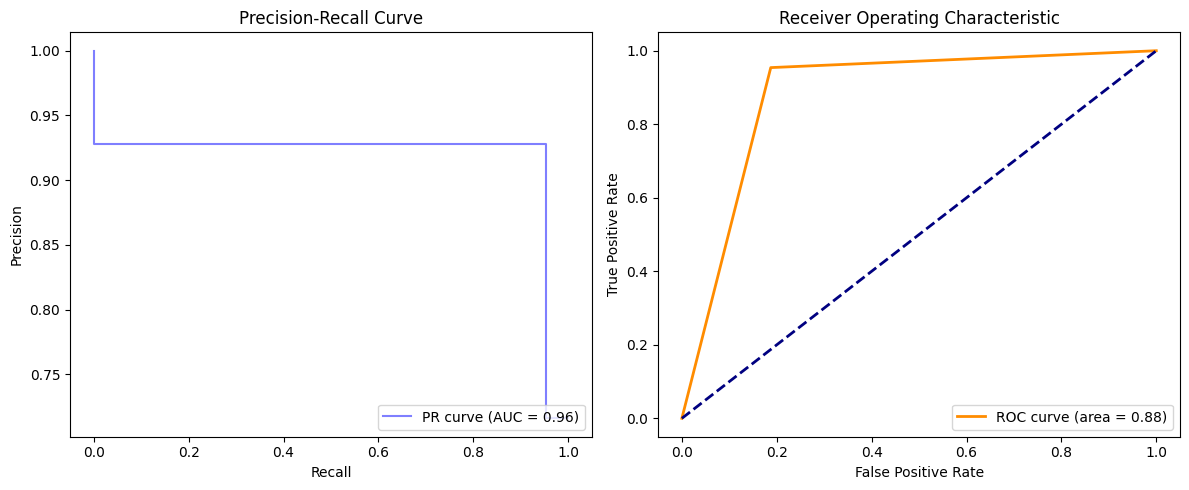

In [ ]:
# Instance of the Random Forest Classifier
rfc_2 = RandomForestClassifier()

# Parameter distributions
param_distributions = {
    'n_estimators': randint(10, 200),  # Number of trees in the forest
    'max_depth': [None] + list(randint(1, 20).rvs(5)),  # Maximum depth of the tree
    'min_samples_split': randint(2, 11),
    # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 11),
    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],  # Method of selecting samples for training each tree
}

rfc_2_accuracy, rfc_2_precision, rfc_2_recall, rfc_2_f1 = evaluate_tsne_classifier(rfc_2,
                                                                                   param_distributions,
                                                                                   X_train,
                                                                                   y_train,
                                                                                   X_test,
                                                                                   y_test)

**Evaluation**

Bootstrap (False): Bootstrap is a method of sampling data points with replacement. Setting it to False means that the entire dataset is used for each tree.

Max Depth (10): Max depth represents the maximum depth of the tree. It controls the maximum number of levels in each decision tree.

Min Samples Leaf (3): Min samples leaf sets the minimum number of samples required to be at a leaf node. It controls the minimum size of terminal nodes. Slightly lower than the PCA one.

Min Samples Split (5): Min samples split sets the minimum number of samples required to split an internal node. It controls the minimum size of nodes that can be split.

N Estimators (40): N estimators is the number of trees in the forest.

Accuracy (0.9139): Approximately 91.4% of the model's predictions are correct.

Precision (0.9277): When the model predicts a positive outcome, it is correct about 92.77% of the time.

Recall (0.9541): The model identifies approximately 95.41% of all actual positive instances.

F1 Score (0.9407): This F1 score suggests a strong balance between precision and recall.

Precision-Recall Curve: Here we see that at a precision of about 0.87 we stay constant at a recall until about 0.95, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.96.

ROC-Curve: The ROC curve area underneath is 0.88. The model is doing well, but compared to the PCA data RF, it is a little bit worse.

Based on what we saw with PCA data with 30 components, using the t-SNE data we get a RF that is just slightly worse, only by 1% in accuracy, nonetheless, this random forest model preforms very well.  

4. Logistic Regression

Best Hyperparameters: {'C': 8.362559109194317, 'max_iter': 72, 'solver': 'sag'}
Accuracy: 0.8708133971291866
Precision: 0.8889770023790642
Recall: 0.9365079365079365
F1 Score: 0.9121236777868185


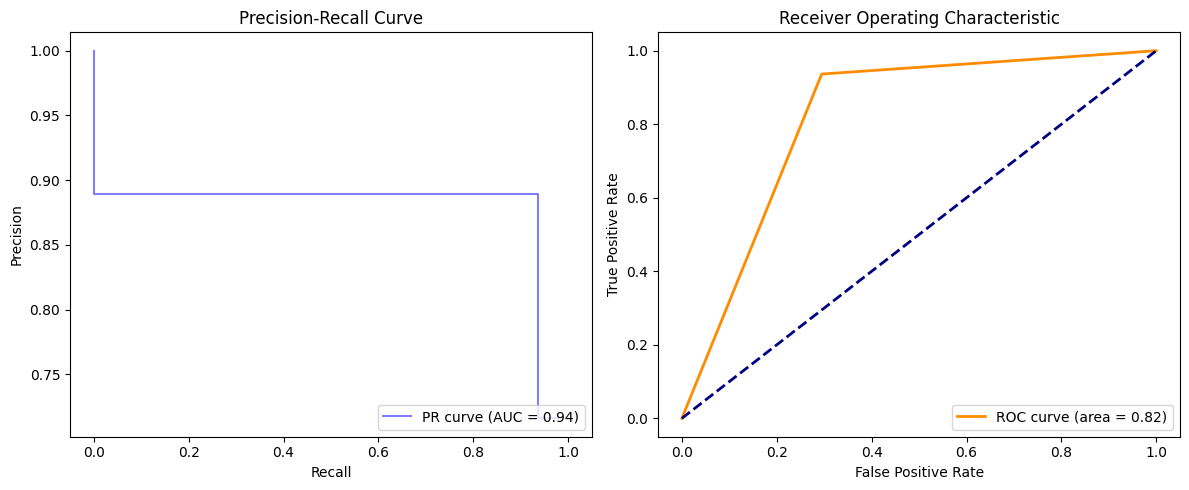

In [ ]:
# Instance of the Logistic Regression
logreg_2 = LogisticRegression()

# Parameter distributions
param_distributions = {
    'C': uniform(0.001, 10),  # Inverse of regularization strength
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    # Algorithm to use in the optimization problem
    'max_iter': randint(50, 200),  # Maximum number of iterations for optimization
}

logreg_2_accuracy, logreg_2_precision, logreg_2_recall, logreg_2_f1 = evaluate_tsne_classifier(logreg_2,
                                                                                               param_distributions,
                                                                                               X_train,
                                                                                               y_train,
                                                                                               X_test,
                                                                                               y_test)

**Evaluation**

C (8.36): C is the inverse of the regularization strength. Smaller values specify stronger regularization. In this case, a relatively large C indicates weaker regularization.

Max Iter (72): Max iter represents the maximum number of iterations taken for the solver to converge. This is the same as the last logistic regression model with PCA data.

Solver ('sag'): Solver is the algorithm to use in the optimization problem. 'sag' stands for Stochastic Average Gradient, which is suitable for large datasets. Last time it was LBFGS.

Accuracy (0.8708): Approximately 87.1% of the model's predictions are correct.

Precision (0.8890): When the model predicts a positive outcome, it is correct about 88.9% of the time.

Recall (0.9365): The model identifies approximately 93.7% of all actual positive instances.

F1 Score (0.9121): This F1 score suggests a strong balance between precision and recall.

Precision-Recall Curve: Here we see that at a precision of about 0.87 we stay constant at a recall until about 0.95, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.94.

ROC-Curve: The ROC curve area underneath is 0.82. The model is not doing well compared to what we had before with PCA data.

Based on what we saw with PCA data with 30 components, using the t-SNE data we get a logistic regression model that is worse by about 5% in accuracy. This model is underpreforming. The trend seems to be that the lower amount of variates in the model (or data points inputted) decreases the models abilities to distinguish well between pneumonia and normal scans, the logistic regression model needs a bit more infomration than what we are giving it.

5. K nearest Neighbours

Best Hyperparameters: {'n_neighbors': 17, 'p': 2, 'weights': 'distance'}
Accuracy: 0.9198564593301436
Precision: 0.9289749798224375
Recall: 0.9615705931495405
F1 Score: 0.944991789819376


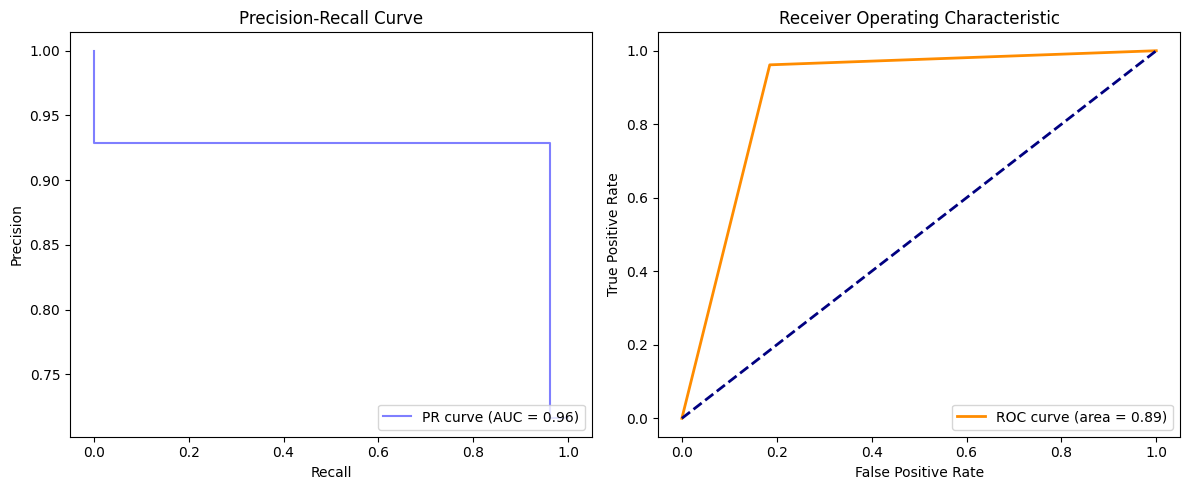

In [ ]:
# Instance of the KNN Classifier
knn_2 = KNeighborsClassifier()

# Parameter distributions
param_distributions = {
    'n_neighbors': randint(1, 20),  # Number of neighbors to use for classification
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric
}

knn_2_accuracy, knn_2_precision, knn_2_recall, knn_2_f1 = evaluate_tsne_classifier(knn_2,
                                                                                   param_distributions,
                                                                                   X_train,
                                                                                   y_train,
                                                                                   X_test,
                                                                                   y_test)

**Evaluation**

n_neighbors (17): It is the number of neighbors to consider for each data point during classification.

p (2): It represents the power parameter for the Minkowski distance metric. In this case, p=2 indicates the use of the Euclidean distance.

weights ('distance'): It specifies the weight function used in prediction. 'distance' means closer neighbors have more influence than farther ones.

Accuracy (0.9199): Approximately 92.0% of the model's predictions are correct.

Precision (0.9290): When the model predicts a positive outcome, it is correct about 92.9% of the time.

Recall (0.9616): The model identifies approximately 96.2% of all actual positive instances.

F1 Score (0.9450): This F1 score suggests a strong balance between precision and recall.

Precision-Recall Curve: Here we see that at a precision of about 0.87 we stay constant at a recall until about 0.95, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.96.

ROC-Curve: The ROC curve area underneath is 0.89. This model is doing an about average job at discriminating between the pneumonia and the normal classes.

Based on what we saw with PCA data with 30 components, using the t-SNE data we get a KNN model that is about identical in accuracy. Both of the two KNN models are about 92% accurate. I think what is happening here is the concept of the "curse of dimesnionality": In high-dimensional spaces, the concept of "closeness" becomes less meaningful due to the increased sparsity of data. As the number of dimensions increases, the distance between points tends to increase, making it challenging for KNN to find meaningful neighbors. We can see that even with more data points (30 vs 6), the accuracy does not really change at all.

6. Niave Gaussin Bayes

Best Hyperparameters: {'var_smoothing': 8.361659109194318e-06}
Accuracy: 0.8498803827751196
Precision: 0.8457602339181286
Recall: 0.9665831244778613
F1 Score: 0.9021442495126705


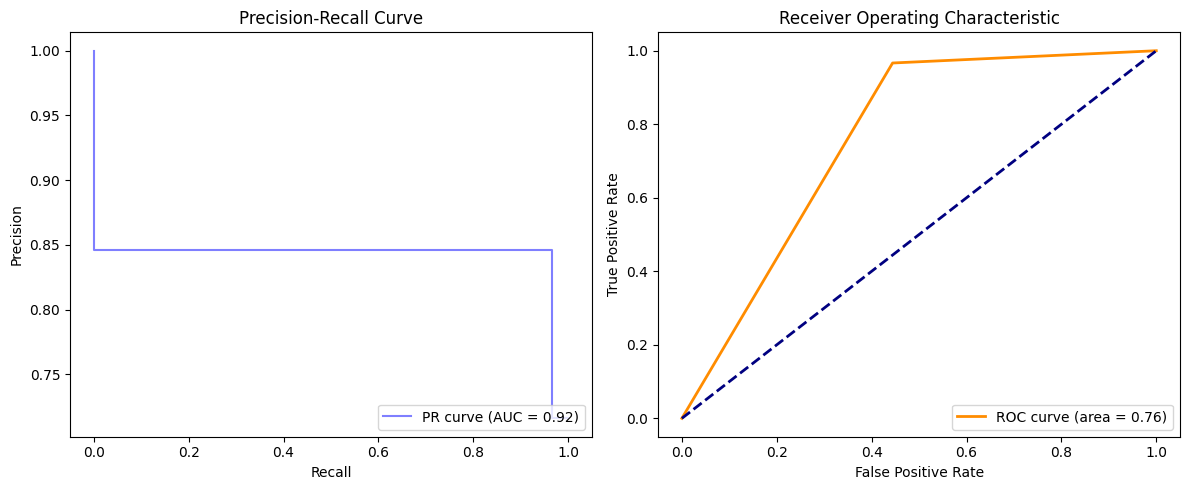

In [ ]:
# Create an instance of the Gaussian Naive Bayes classifier
nbcl_2 = GaussianNB()

# Define the parameter distributions
param_distributions = {
    'var_smoothing': uniform(1e-10, 1e-5)
}

nbcl_2_accuracy, nbcl_2_precision, nbcl_2_recall, nbcl_2_f1 = evaluate_tsne_classifier(nbcl_2,
                                                                                       param_distributions,
                                                                                       X_train,
                                                                                       y_train,
                                                                                       X_test,
                                                                                       y_test)

**Evaluation**

Var_smoothing: 8.361659109194318e-06 (This is the smoothing parameter for variance. It's a technique used to handle instances where the variance of a particular feature is zero in a specific class. The small value helps avoid division by zero during probability calculations.)

Accuracy (0.8499): Approximately 85.0% of the model's predictions are correct.

Precision (0.8458): When the model predicts a positive outcome, it is correct about 84.6% of the time.

Recall (0.9666): The model identifies approximately 96.7% of all actual positive instances.

F1 Score (0.9021): This F1 score suggests a strong balance between precision and recall, it is slightly lower than what we have been seeing.

Precision-Recall Curve: Here we see that at a precision of about 0.85 we stay constant at a recall until about 0.95, where in order to add any more recall, the precision must go down. The over all area under the curve is 0.92.

ROC-Curve: The ROC curve area underneath is 0.76. This model is not doing a good job at discriminating between the pneumonia and the normal classes.

Again, the GNB is underpreforming, like it consistently has been doing. Here is my intuition on why it is underpreforming:

- GNB assumes that the features are normally distributed within each class, which might not hold true for complex and high-dimensional data like chest X-ray images. Chest X-rays often exhibit intricate patterns and structures that may not be well-modeled by the simplistic Gaussian distribution assumption.

- GNB assumes independence between features, which might not be the case for spatially correlated pixel values in an image. Chest X-rays contain intricate spatial relationships and patterns that are crucial for accurately identifying pneumonia. The oversimplified assumption of feature independence may lead to suboptimal performance in capturing the nuanced relationships present in the data.

- GNB may struggle with imbalanced classes or misclassifying instances with overlapping feature distributions. In medical datasets, where positive cases (pneumonia) might be significantly outnumbered by negatives, GNB's performance could be impacted.



7. Multilayer Network

This network is essential identical to the one we saw before with PCA data, so we will not explain how each step works and the architecture of the model.

Epoch 1/50
140/140 [==============================] - 1s 4ms/step - loss: 0.4668 - accuracy: 0.7918 - val_loss: 0.2900 - val_accuracy: 0.9176
Epoch 2/50
140/140 [==============================] - 0s 3ms/step - loss: 0.3439 - accuracy: 0.8766 - val_loss: 0.2436 - val_accuracy: 0.9211
Epoch 3/50
140/140 [==============================] - 0s 3ms/step - loss: 0.3217 - accuracy: 0.8890 - val_loss: 0.2375 - val_accuracy: 0.9211
Epoch 4/50
140/140 [==============================] - 0s 3ms/step - loss: 0.3123 - accuracy: 0.8950 - val_loss: 0.2311 - val_accuracy: 0.9229
Epoch 5/50
140/140 [==============================] - 0s 3ms/step - loss: 0.3045 - accuracy: 0.8921 - val_loss: 0.2287 - val_accuracy: 0.9211
Epoch 6/50
140/140 [==============================] - 0s 3ms/step - loss: 0.3068 - accuracy: 0.8946 - val_loss: 0.2283 - val_accuracy: 0.9265
Epoch 7/50
140/140 [==============================] - 0s 3ms/step - loss: 0.2977 - accuracy: 0.8952 - val_loss: 0.2267 - val_accuracy: 0.9265
Epoch 

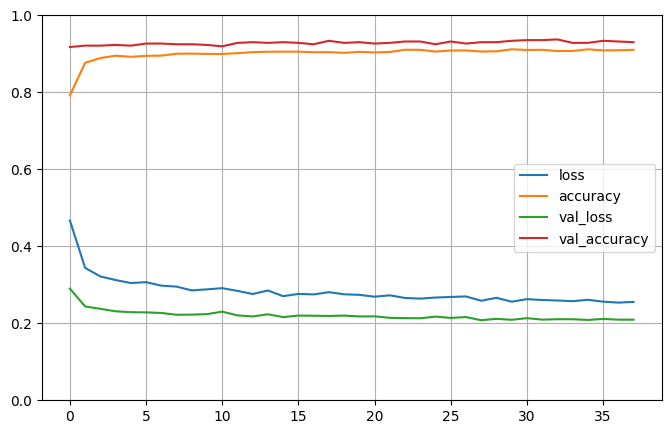

18/18 [==============================] - 0s 2ms/step
Accuracy: 0.9174147217235189
Precision: 0.9168287582629273
Recall: 0.9174147217235189
F1 Score: 0.9156128361928473


In [ ]:
keras.backend.clear_session()
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3010)

# Generate the indices for the training and testing sets based on stratified sampling
for train_index, test_index in stratified_split.split(X_normalized_tsne, y):
    X_train_nn = X_normalized_tsne[train_index]
    X_test_nn = X_normalized_tsne[test_index]
    y_train_nn = y[train_index]
    y_test_nn = y[test_index]

# Split the training data into training and validation sets 50/50
X_test_nn, X_val_nn, y_test_nn, y_val_nn = train_test_split(X_test_nn, y_test_nn,
                                                            test_size=0.5,
                                                            random_state=3010)


# Define the model
simple_network_22 = Sequential()
simple_network_22.add(Dense(128, activation="relu", input_shape=(6,)))
simple_network_22.add(Dropout(0.5))
simple_network_22.add(Dense(64, activation="relu"))
simple_network_22.add(Dropout(0.5))
simple_network_22.add(Dense(2, activation="sigmoid"))

# Compile the model
simple_network_22.compile(loss="sparse_categorical_crossentropy",
                         optimizer="adam",
                         metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history_simple_22 = simple_network_22.fit(X_train_nn, y_train_nn,
                                       epochs=50,
                                       validation_data=(X_val_nn, y_val_nn),
                                       callbacks=[early_stopping])

# Plot learning curves
pd.DataFrame(history_simple_22.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# use the model
y_pred_22 = np.argmax(simple_network_22.predict(X_test_nn), axis=1)

#get the metrics
classification_result = classification_report(y_test_nn, y_pred_22,
                                              target_names=['class 0', 'class 1'],
                                              output_dict=True)

# Extract metrics
accuracy_nn22 = classification_result['accuracy']
precision_nn22 = classification_result['weighted avg']['precision']
recall_nn22 = classification_result['weighted avg']['recall']
f1_score_nn22 = classification_result['weighted avg']['f1-score']

print("Accuracy:", accuracy_nn22)
print("Precision:", precision_nn22)
print("Recall:", recall_nn22)
print("F1 Score:", f1_score_nn22)

There is no real evidence of over or underfitting here. The network preforms worse than the one with PCA data. This is just due to the complexity and amount of input points into the layer. This network stops early at the 38th epoch, where the network before stopped at the 13th epoch. They have different learning rates, again which is due to the complexity of the data input. The first network with PCA data get more input points and thus it sees complex relationships more often and can learn faster. Here the t-SNE data has less data points so it takes the network significantly longer to learn te relationships and predict. We still get an accuracy of 91%, which is not terrible.

In [ ]:
results_2 = {
    'SGDC': [sgdc_2_accuracy, sgdc_2_precision[1], sgdc_2_recall[1], sgdc_2_f1],
    'SVM': [svc_2_accuracy, svc_2_precision[1], svc_2_recall[1], svc_2_f1],
    'RF': [rfc_2_accuracy, rfc_2_precision[1], rfc_2_recall[1], rfc_2_f1],
    'LOGREG': [logreg_2_accuracy, logreg_2_precision[1], logreg_2_recall[1], logreg_2_f1],
    'KNN': [knn_2_accuracy, knn_2_precision[1], knn_2_recall[1], knn_2_f1],
    'NB': [nbcl_2_accuracy, nbcl_2_precision[1], nbcl_2_recall[1], nbcl_2_f1],
    'NN1': [accuracy_nn22, precision_nn22, recall_nn22, f1_score_nn22],
}

rounded_results_2 = {key: [round(value, 3) for value in values] for key,
                     values in results_2.items()}

# Create a DataFrame from the dictionary
df_tsne = pd.DataFrame(rounded_results_2, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Print the DataFrame
print("With t-SNE (6 dimension) and Hyperparameter Tuning")
print(df_tsne.T) #.T transposes and swaps the rows and the columns so its formatted nicer
print(" ")
print(" ")
print(" ")
print(" ")
print("With PCA (30 dimensions) and Hyperparameter Tuning")
print(df_pca.T)

With t-SNE (6 dimension) and Hyperparameter Tuning
        Accuracy  Precision  Recall  F1 Score
SGDC       0.870      0.875   0.956     0.913
SVM        0.922      0.930   0.963     0.946
RF         0.914      0.928   0.954     0.941
LOGREG     0.871      0.889   0.937     0.912
KNN        0.920      0.929   0.962     0.945
NB         0.850      0.846   0.967     0.902
NN1        0.917      0.917   0.917     0.916
 
 
 
 
With PCA (30 dimensions) and Hyperparameter Tuning
        Accuracy  Precision  Recall  F1 Score
SGDC       0.927      0.933   0.967     0.950
SVM        0.946      0.955   0.970     0.962
RF         0.928      0.930   0.972     0.951
LOGREG     0.926      0.942   0.957     0.949
KNN        0.925      0.941   0.955     0.948
NB         0.897      0.896   0.968     0.931
NN1        0.946      0.946   0.946     0.946
NN2        0.944      0.944   0.944     0.944


It seems like our PCA models are the way to go. We get the most accuracy and the best scores with PCA. It takes much less time to run than t-SNE with 6 dimesnions, which takes approximetely 30 minutes to run. PCA with 30 dimensions takes about 1 minute. For the scale of our project and the available computational units, we would choose PCA redcued x-ray data, it preforms better and takes less amount of time to run.  

#Convolutional NN

Why are CNN's best suited for our task of classifying pneumonia or normal chest x-ray images?

- CNNs automatically learn hierarchical representations of features within an image. In the context of chest X-rays, these networks can capture intricate patterns and structures at different levels, from edges and textures to more complex spatial arrangements indicative of pneumonia.

- CNNs are designed to understand the spatial relationships between pixels. In chest X-rays, the spatial arrangement of abnormalities and the context of surrounding areas are crucial for accurate diagnosis. CNNs can learn and leverage these spatial dependencies effectively.

- CNNs use shared weights (filters) across different parts of the image, which significantly reduces the number of parameters compared to fully connected networks. This makes CNNs more computationally efficient and capable of learning from large image datasets.

- CNN architectures can be adapted to accommodate various input sizes and modalities. This flexibility is crucial in medical imaging where images can vary in resolution and format.

In [ ]:
X = np.array(X)
y = np.array(y)
X = np.array([x.reshape((256, 256)) for x in X])

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3010)

# Generate the indices for the training and testing sets based on stratified sampling
for train_index, test_index in stratified_split.split(X, y):
    X_train_nn, X_test_nn = X[train_index], X[test_index]
    y_train_nn = y[train_index]
    y_test_nn = y[test_index]

# Split the testing data into training and validation sets 50/50
X_test_nn, X_val_nn, y_test_nn, y_val_nn = train_test_split(X_test_nn,
                                                            y_test_nn,
                                                            test_size=0.5,
                                                            random_state=3010)

Simple CNN

We start with an extremly simple CNN to see how it preforms.

Epoch 1/50
140/140 [==============================] - 3s 13ms/step - loss: 30.1882 - accuracy: 0.8672 - val_loss: 0.1836 - val_accuracy: 0.9265
Epoch 2/50
140/140 [==============================] - 1s 11ms/step - loss: 0.1369 - accuracy: 0.9524 - val_loss: 0.1772 - val_accuracy: 0.9355
Epoch 3/50
140/140 [==============================] - 1s 10ms/step - loss: 0.0748 - accuracy: 0.9738 - val_loss: 0.3148 - val_accuracy: 0.9014
Epoch 4/50
140/140 [==============================] - 1s 10ms/step - loss: 0.0377 - accuracy: 0.9883 - val_loss: 0.2169 - val_accuracy: 0.9427
Epoch 5/50
140/140 [==============================] - 1s 10ms/step - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.2884 - val_accuracy: 0.9391
Epoch 6/50
140/140 [==============================] - 1s 10ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.2255 - val_accuracy: 0.9516
Epoch 7/50
140/140 [==============================] - 1s 10ms/step - loss: 0.0311 - accuracy: 0.9917 - val_loss: 0.2693 - val_accuracy: 0.906

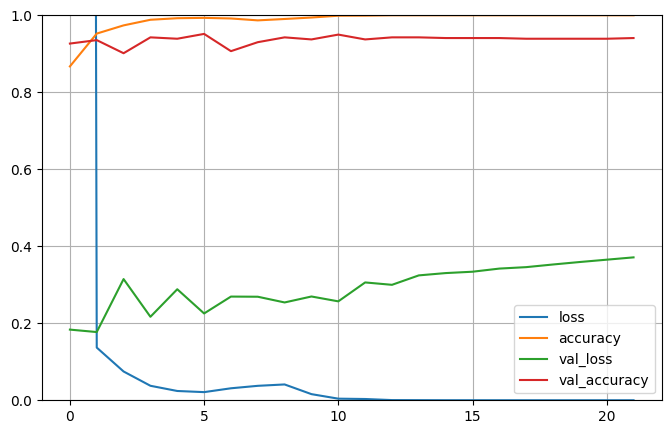

18/18 [==============================] - 0s 5ms/step - loss: 0.2017 - accuracy: 0.9228


[0.20167556405067444, 0.9228007197380066]

In [ ]:
# most simple CNN
keras.backend.clear_session()

most_simple_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='sigmoid')
])

most_simple_cnn.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history_most_simple = most_simple_cnn.fit(X_train_nn, y_train_nn, epochs=50,
                        validation_data=(X_val_nn, y_val_nn),
                        callbacks=[early_stopping])

# Plot learning curves
pd.DataFrame(history_most_simple.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Evaluate on the test set
most_simple_cnn.evaluate(X_test_nn, y_test_nn)

92% but we are overfitting, so lets try a more complex and deeper model to see if we can achive something better.

CNN Model 2 (More Complex)

1. Input Layer (Conv2D):

- Filters: 64
- Kernel Size: 7x7
- Activation: ReLU
- Padding: Same
- Input Shape: (256, 256, 1) - indicating a single-channel (grayscale) image
- Batch Normalization is applied after this convolutional layer.

2. MaxPooling2D Layer:
- Pool Size: 2x2. Reduces the spatial dimensions by taking the maximum value in each 2x2 region.

3. Convolutional Blocks (Repeat Twice):
- Conv2D Layer (Filters: 128, Kernel Size: 3x3, Activation: ReLU, Padding: Same)
- Conv2D Layer (Filters: 128, Kernel Size: 3x3, Activation: ReLU, Padding: Same)
- Batch Normalization is applied after these convolutional layers.
- MaxPooling2D Layer (Pool Size: 2x2)

4. Convolutional Blocks (Repeat Twice):
- Conv2D Layer (Filters: 256, Kernel Size: 3x3, Activation: ReLU, Padding: Same)
- Conv2D Layer (Filters: 256, Kernel Size: 3x3, Activation: ReLU, Padding: Same)
- Batch Normalization is applied after these convolutional layers.
- MaxPooling2D Layer (Pool Size: 2x2)

5. Flatten Layer:
- Flattens the output of the last convolutional layer to prepare for the fully connected layers.

6. Fully Connected (Dense) Layers:
- Dense Layer (Units: 128, Activation: ReLU)
- Batch Normalization is applied after this dense layer.
- Dropout Layer (Dropout Rate: 0.5) - Helps prevent overfitting by randomly dropping connections during training.
- Dense Layer (Units: 64, Activation: ReLU)
- Batch Normalization is applied after this dense layer.
- Dropout Layer (Dropout Rate: 0.5)

7. Output Layer:
- Dense Layer (Units: 2, Activation: Sigmoid) - Outputs two values representing the probability distribution for the two classes.

8. Compilation:
- Loss Function: Sparse Categorical Crossentropy - Suitable for classification tasks.
- Optimizer: Adam - An adaptive learning rate optimization algorithm.
- Metrics: Accuracy - Monitoring the accuracy during training.

9. Early Stopping:
- Monitors validation loss and stops training if no improvement is observed after a certain number of epochs (patience=20). It restores the best weights observed during training.

Epoch 1/50
140/140 [==============================] - 10s 49ms/step - loss: 0.4504 - accuracy: 0.8288 - val_loss: 7.7178 - val_accuracy: 0.4211
Epoch 2/50
140/140 [==============================] - 6s 46ms/step - loss: 0.2801 - accuracy: 0.9006 - val_loss: 2.5255 - val_accuracy: 0.7832
Epoch 3/50
140/140 [==============================] - 7s 47ms/step - loss: 0.2319 - accuracy: 0.9186 - val_loss: 0.2614 - val_accuracy: 0.9014
Epoch 4/50
140/140 [==============================] - 6s 46ms/step - loss: 0.1883 - accuracy: 0.9352 - val_loss: 0.4732 - val_accuracy: 0.8351
Epoch 5/50
140/140 [==============================] - 6s 46ms/step - loss: 0.1653 - accuracy: 0.9489 - val_loss: 0.2249 - val_accuracy: 0.8961
Epoch 6/50
140/140 [==============================] - 6s 46ms/step - loss: 0.1690 - accuracy: 0.9403 - val_loss: 0.1155 - val_accuracy: 0.9606
Epoch 7/50
140/140 [==============================] - 6s 46ms/step - loss: 0.1358 - accuracy: 0.9542 - val_loss: 0.4776 - val_accuracy: 0.810

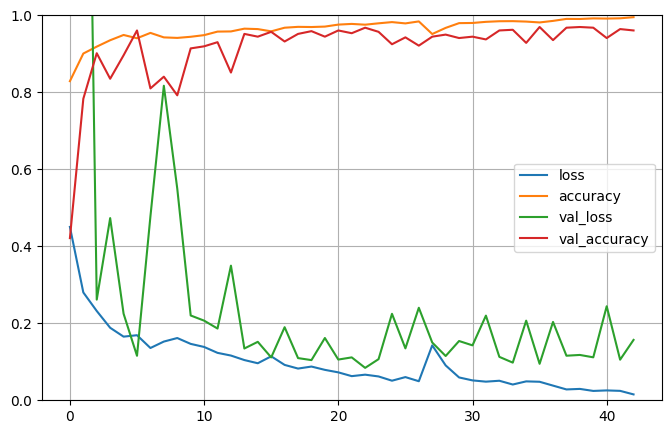

18/18 [==============================] - 0s 14ms/step - loss: 0.1145 - accuracy: 0.9533


[0.11454418301582336, 0.9533213376998901]

In [ ]:
keras.backend.clear_session()

CNN_model_2 = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=7, activation='relu', padding='same',
                        input_shape=(256, 256, 1)),
    BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])

# Compile the model
CNN_model_2.compile(loss="sparse_categorical_crossentropy",
                         optimizer="adam",
                         metrics=["accuracy"])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history_cnn = CNN_model_2.fit(X_train_nn, y_train_nn, epochs=50,
                                          validation_data=(X_val_nn, y_val_nn),
                                          callbacks=[early_stopping])

# Plot learning curves
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Evaluate the model on the test set
CNN_model_2.evaluate(X_test_nn, y_test_nn)

So based on the learning here, we can see that the model has troubles at the start with large jumps in the loss. Eventually over time this evens out and we see evidence that the model is well trained, well fit, and accurate. There is no real alarming significant gaps between the validation accuracy and the accuarcy. The same applies for the loss, except that the validation loss slightly jumps around, this is due to the stochastic nature of the learning, but we can see that these jumps are significantly decreased as the epoches increase. We apply early stopping at epoch 43, here the model is not really getting any better so we quit training and evaluate. We end up getting the highest accuracy thus far for the entire project at just above 95%. I am very happy with the result of this CNN model.

In [ ]:

y_pred = CNN_model_2.predict(X_test_nn)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_nn, y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)

18/18 [==============================] - 0s 14ms/step
Confusion Matrix:
[[149   8]
 [ 18 382]]


The confusion matrix shows that of the positive class 382 were accurately predicted to be pneumonia images. 149 were coreectly predicted to be normal images. 8 were false positives, meaning they were normal images but predicted to be pneumonia images. 18 were false negatives, they were pneumonia images but predicted to be normal images.

In [ ]:
# Assuming CNN_model_2 is your trained model
y_pred = np.argmax(CNN_model_2.predict(X_test_nn), axis=1)


# Calculate metrics
accuracy = accuracy_score(y_test_nn, y_pred)
precision = precision_score(y_test_nn, y_pred)
recall = recall_score(y_test_nn, y_pred)
f1 = f1_score(y_test_nn, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

18/18 [==============================] - 0s 14ms/step
Accuracy: 0.9533213644524237
Precision: 0.9794871794871794
Recall: 0.955
F1 Score: 0.9670886075949366


Overall this CNN preforms the best and was the most powerful model that we could create during this project. In practice, a CNN adapted model could be made to actually analyze chest x-ray images and make diagnosis. We only had about 5000 images, but the ability of the model would be greatly increased with the avilibility of more data. But with the amount of data that was available from kaggle, 95% is still exceptional, I am happy with how this model turned out.